<font size = '5'>**Разработка модели предсказания популярности поста** </font>

Постановка задачи: Паблики в соцсетях являются важным инструментом для продвижения организаций. Чем больше реакций (репостов/лайков/упоминаний) тем выше популярность и узнаваемость. Нужно научиться определять что именно в постах влияет на их популярность. Вам предстоит подготовить датасет, разработать и обучить модель, после чего проанализировать важность ее признаков и их влияние популярность постов. 

Цель: Разработать модель предсказания популярности поста и подготовить отчет, в котором будут рекомендации для Заказчика по формированию поста - на что нужно больше всего обращать внимание при его создании, чтобы максимизировать его популярность.
Исходные данные: История постов с 10+ пабликов из соцсетей в CSV формате. Ссылка на данные - https://disk.yandex.ru/d/5Y3Zj2SYxPEfgw Информация о пабликах - https://docs.google.com/document/d/1bXknW30wP0ka-_w6GTGZocseT4f7PPLCLlON5s6OWHQ/edit

# Подготовка данных

In [161]:
#!pip install pymorphy2

In [162]:
import pandas as pd
import numpy as np
import phik
import re
import shap
from shap import Explanation
from pandarallel import pandarallel

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import pymorphy2
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200
RANDOM_STATE = 42
sampler = TPESampler(seed=42)
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
vk1 = pd.read_csv('D:/vk/new_data/vk_artbazar_61.csv')
vk2 = pd.read_csv('D:/vk/new_data/vk_c52space.csv')
vk3 = pd.read_csv('D:/vk/new_data/vk_centr_step.csv')
vk4 = pd.read_csv('D:/vk/new_data/vk_d30space.csv')
vk5 = pd.read_csv('D:/vk/new_data/vk_dspl_rostov.csv')
vk6 = pd.read_csv('D:/vk/new_data/vk_makaronka_space.csv')
vk7 = pd.read_csv('D:/vk/new_data/vk_mayak.lektory.csv')
vk8 = pd.read_csv('D:/vk/new_data/vk_msiid.csv')
vk9 = pd.read_csv('D:/vk/new_data/vk_n_s_rnd.csv')
vk10 = pd.read_csv('D:/vk/new_data/vk_rostov.csv')
vk11 = pd.read_csv('D:/vk/new_data/vk_sholokhovrostov.csv')

In [164]:
tg1 = pd.read_csv('D:/vk/new_data/tg_dsplrostov.csv')
tg2 = pd.read_csv('D:/vk/new_data/tg_rostov_gallery.csv')
ns = pd.read_csv('D:/vk/new_data/n_s_rnd.csv')

In [165]:
vk1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1216 non-null   int64  
 1   date            1216 non-null   object 
 2   text            1049 non-null   object 
 3   is_pinned       1216 non-null   float64
 4   attachments     1216 non-null   float64
 5   post_source     1216 non-null   object 
 6   comments        1216 non-null   int64  
 7   likes           1216 non-null   int64  
 8   reposts         1216 non-null   int64  
 9   views           1216 non-null   float64
 10  len_text        1216 non-null   int64  
 11  post_source_id  1216 non-null   int64  
 12  year            1216 non-null   int64  
 13  month           1216 non-null   int64  
 14  dayofweek       1216 non-null   int64  
 15  hour            1216 non-null   int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 152.1+ KB


In [166]:
tg1.info()
tg2.info()
ns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msg_id           937 non-null    int64 
 1   sender           937 non-null    object
 2   sender_id        937 non-null    object
 3   reply_to_msg_id  937 non-null    int64 
 4   date             937 non-null    object
 5   msg_type         937 non-null    object
 6   msg_content      937 non-null    object
 7   has_mention      937 non-null    int64 
 8   has_email        937 non-null    int64 
 9   has_phone        937 non-null    int64 
 10  has_hashtag      937 non-null    int64 
 11  is_bot_command   937 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 88.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msg_id      

In [167]:
tg1.dtypes == ns.dtypes

msg_id             True
sender             True
sender_id          True
reply_to_msg_id    True
date               True
msg_type           True
msg_content        True
has_mention        True
has_email          True
has_phone          True
has_hashtag        True
is_bot_command     True
dtype: bool

In [168]:
vk1.dtypes == vk7.dtypes

Unnamed: 0         True
date               True
text               True
is_pinned          True
attachments        True
post_source        True
comments           True
likes              True
reposts            True
views             False
len_text           True
post_source_id     True
year               True
month              True
dayofweek          True
hour               True
dtype: bool

Некоторые числовые поля датасетов `vk` содержат где то данные типа int, где то float. Нам это не помешает объединить датасеты. Прежде чем объединять, удалим в датасетах vk пропущенные значения, тк там пропущено содержание самих постов, что является очень важной информацией.

In [169]:
tg_df = [tg1, tg2, ns]
tg_keys = ['dsplrostov', 'rostov_gallery', 's_rnd']
tg = pd.concat(tg_df, keys=tg_keys)

In [170]:
tg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3888 entries, ('dsplrostov', 0) to ('s_rnd', 852)
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msg_id           3888 non-null   int64 
 1   sender           3888 non-null   object
 2   sender_id        3888 non-null   object
 3   reply_to_msg_id  3888 non-null   int64 
 4   date             3888 non-null   object
 5   msg_type         3888 non-null   object
 6   msg_content      3888 non-null   object
 7   has_mention      3888 non-null   int64 
 8   has_email        3888 non-null   int64 
 9   has_phone        3888 non-null   int64 
 10  has_hashtag      3888 non-null   int64 
 11  is_bot_command   3888 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 456.9+ KB


In [171]:
tg

msg_id            sender          sender_id  reply_to_msg_id  \
dsplrostov 0         3          Публичка  channel1698358110               -1   
           1         4          Публичка  channel1698358110               -1   
           2         5          Публичка  channel1698358110               -1   
           3         6          Публичка  channel1698358110               -1   
           4         7          Публичка  channel1698358110               -1   
...                ...               ...                ...              ...   
s_rnd      848     944  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           849     945  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           850     946  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           851     947  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           852     948  НИЧЕГО СТРАШНОГО  channel1486494176               -1   

                               date msg_type  \
dsplrostov 0    2022-03-01 11:55:15     text   
           1    2022-03-01 14:00:21    photo   
           2    2022-03-01 15:56:34    photo   
           3    2022-03-01 15:56:34    photo   
           4    2022-03-01 16:00:46     text   
...                             ...      ...   
s_rnd      848  2022-12-08 23:09:41    photo   
           849  2022-12-08 23:09:41    photo   
           850  2022-12-08 23:09:41    photo   
           851  2022-12-15 14:19:55    photo   
           852  2022-12-30 13:57:47     link   

                                                                                                                                                                                                            msg_content  \
dsplrostov 0                             Дорогие друзья, теперь у нас появился телеграм-канал📱  Здесь мы будем информировать вас о самых интересных событиях библиотеки 👌👌 и, конечно, ждать обратной связи!  Welcome 🤗   
           1                                                                                                                                           (File not included. Change data exporting settings to download.)   
           2                                                                                                                                           (File not included. Change data exporting settings to download.)   
           3                                                                                                                                           (File not included. Change data exporting settings to download.)   
           4    ❗Не забываем, что при посещении библиотеки необходимо предъявить QR-код либо сертификат, подтверждающий прививку от COVID-19, или справку либо сертификат о перенесенном коронавирусе (не позднее 6 ...   
...                                                                                                                                                                                                                 ...   
s_rnd      848                                                                                                                                         (File not included. Change data exporting settings to download.)   
           849                                                                                                                                         (File not included. Change data exporting settings to download.)   
           850                                                                                                                                         (File not included. Change data exporting settings to download.)   
           851                                                                                                                                         (File not included. Change data exporting settings to download.)   
           852                                                       

In [172]:
vk_df = [vk1, vk2, vk3, vk4, vk5, vk6, vk7, vk8, vk9, vk10, vk11]
vk_keys = ['artbazar_61', 'c52space', 'centr_step', 'd30space', 'dspl_rostov', 'makaronka_space',
           'mayak.lektory', 'msiid', 'n_s_rnd', 'rostov', 'sholokhovrostov']
for df in vk_df:
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
vk = pd.concat(vk_df, keys=vk_keys)
vk = vk.drop('Unnamed: 0', axis=1)

In [173]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12402 entries, ('artbazar_61', 0) to ('sholokhovrostov', 503)
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            12402 non-null  object 
 1   text            12402 non-null  object 
 2   is_pinned       12402 non-null  float64
 3   attachments     12402 non-null  float64
 4   post_source     12402 non-null  object 
 5   comments        12402 non-null  int64  
 6   likes           12402 non-null  int64  
 7   reposts         12402 non-null  float64
 8   views           12402 non-null  float64
 9   len_text        12402 non-null  int64  
 10  post_source_id  12402 non-null  int64  
 11  year            12402 non-null  int64  
 12  month           12402 non-null  int64  
 13  dayofweek       12402 non-null  int64  
 14  hour            12402 non-null  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 1.6+ MB


In [174]:
vk

date  \
artbazar_61     0    2022-11-03 11:06:58   
                1    2023-02-15 10:42:46   
                2    2023-02-06 13:41:00   
                3    2023-02-06 12:41:00   
                4    2023-02-06 11:41:00   
...                                  ...   
sholokhovrostov 499  2016-01-20 11:51:26   
                500  2016-01-20 11:49:12   
                501  2016-01-20 11:47:33   
                502  2016-01-14 13:05:22   
                503  2016-01-14 12:39:52   

                                                                                                                                                                                                                        text  \
artbazar_61     0                                 Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355   
                1    18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...   
                2                                                            концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽   
                3    День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...   
                4    Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 499  12 июня - 18 сентября 2016 г.\n"ДОМ И МИР НА ПОЛЯРНОМ КРУГЕ"\n\nЯмало-Ненецкий окружной музейно-выставочный комплекс им. И.С. Шемановского\n\nЭкспозиция строится на показе культур оленеводов тундр...   
                500  30 сентября - 4 декабря\n"ТУТ БЫЛ Я СЧАСТЛИВ..."\n\nГосударственный Лермонтовский музей-заповедник «Тарханы»\nГосударственный музей-заповедник М.Ю.Лермонтова (Пятигорск)\nЛитературный музей Инстит...   
                501  16 ДЕКАБРЯ 2016 - 28 ФЕВРАЛЯ 2017 года\n"ГИМН РОССИИ"\n\nВсероссийское музейное объединение музыкальной культуры им. Глинки (Москва)\n\n«Гимн России», где представлена история Государственного гим...   
                502  Почувствуйте себя настоящими кондитерами и ощутите сладкий вкус шоколадной конфеты, созданной своими руками! \nПриходите поэкспериментрировать в нашей "Шоколадной лаборатории"!\nhttp://www.sholokh...   
                503                                                                                                                                                    Приглашаем посетить выставку "Рождественские истории"   

                     is_pinned  attachments post_source  comments  likes  \
artbazar_61     0          1.0          1.0          vk         2      6   
                1          0.0          1.0          vk         0     20   
                2          0.0          1.0          vk         0      2   
                3          0.0          1.0          vk         0      1   
                4          0.0          1.0          vk         0      1   
...                        ...          ...         ...       ...    ...   
sholokhovrostov 499        0.0          3.0          vk         0      2   
                500        0.0          2.0          vk         0      4   
                501        0.0          3.0          vk         0      2   
                502        0.0          6.0          vk   

Почистили от пропущенных значений и объединили датафреймы. По vk видно, что столбцы `date` (в датафрейме уже есть инфо в др столбцах), и `post_source`, скорее всего, можно выкинуть. В tg это столбец `msg_id`. Проверим на дубликаты и аномалии.

In [175]:
vk.post_source.unique() #Пока не дропаем, пока не изучим корреляцию с ЦП

array(['vk', 'api', 'mvk'], dtype=object)

In [176]:
vk = vk.drop('date', axis=1)
tg = tg.drop('msg_id', axis=1)

Приведу поля в ВК с типом float к int, тк значения по логике целочисленные.

In [177]:
vk[['is_pinned', 'attachments', 'reposts', 'views']] = vk[['is_pinned', 'attachments', 'reposts', 'views']].astype('int')

In [178]:
vk.duplicated().sum()

1

Один дубликат в ВК удалять не будем.

In [179]:
tg.duplicated().sum()

1475

Такое большое количество дубликатов в ТГ связано с тем, что много картинок с одинаковыми показателями, но посты разные.

In [180]:
tg.msg_type.unique()

array(['text', 'photo', 'link', 'video_file', 'animation', 'file',
       'sticker', 'video_message', 'poll'], dtype=object)

Из того, что мы видим, имеет смысл дальше работать только с vk. В tg нету никаких фич, которые можно было бы признать целевыми, на основании которых мы могли бы судить о популярности или непопулярности поста.

In [181]:
vk.describe()

,is_pinned,attachments,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour
count,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000
mean,0.000242,1.666183,0.432430,12.469360,1.926302,550.485486,726.492662,0.803499,2019.171343,6.529995,2.588615,10.990405
std,0.015552,1.884068,2.024005,24.236029,3.984878,1004.559897,981.140934,0.397367,2.931039,3.535019,1.765987,3.748438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2011.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,4.000000,0.000000,131.000000,166.000000,1.000000,2018.000000,3.000000,1.000000,8.000000
50%,0.000000,1.000000,0.000000,8.000000,1.000000,356.000000,455.000000,1.000000,2020.000000,6.000000,3.000000,10.000000
75%,0.000000,2.000000,0.000000,15.000000,2.000000,719.000000,914.000000,1.000000,2022.000000,10.000000,4.000000,13.000000
max,1.000000,10.000000,105.000000,2009.000000,114.000000,58951.000000,16087.000000,1.000000,2023.000000,12.000000,6.000000,23.000000


При беглом ознакомлении аномалий не обнаружено.

In [182]:
vk.loc[vk['comments'] == 10]

text  \
c52space    406   Эй, ты живёшь в Ростове и хочешь познакомиться с Сансёрферами☀🏄? Тогда этот анонс для тебя! \n👍👍👍👍👍 \n\n10 Декабря в 16.00 в Главном зале центра "Кластер C52" пройдет первый MeetUp — встреча Сансё...   
            1442  Уважаемые студенты творческих специальностей, если перед вами стоит вопрос о прохождении летней практики в мастерских(рабочая практика), Креативное пространство предоставляет вам возможность пройт...   
            1500  Член команды проекта [club37106921|Ночь Карьеры/ Career night], ответственный за  работу с компаниями,  [id5299634|Елена Шереметцева] составила плейлист из своих любимых композиций специально для ...   
            1622                                                                                                                              Спасибо ребятам из проката и Павлу Платонову за баки для сортировки мусора!   
dspl_rostov 843   28 мая Донская публичная библиотека станет участником всероссийской акции в поддержку чтения - «Библионочь – 2022». Концепция акции напрямую связана с проведением Года культурного наследия народов...   
            1909  1 мая состоялось открытие возрожденного фонтана Публички, реконструкция которого была инициирована Губернатором Ростовской области Голубевым Василием Юрьевичем. В церемонии открытия приняли участи...   
            2440                                                                                                                                                                             Онлайн-концерт "Библиоджаз!"   

                  is_pinned  attachments post_source  comments  likes  \
c52space    406           0            0         api        10      4   
            1442          0            0          vk        10     48   
            1500          0            8          vk        10     34   
            1622          0            0          vk        10     18   
dspl_rostov 843           0            1          vk        10    107   
            1909          0           10          vk        10    112   
            2440          0            1          vk        10     34   

                  reposts  views  len_text  post_source_id  year  month  \
c52space    406         1   2313       675               0  2017     12   
            1442       16      0       511               1  2013      6   
            1500        4      0       315               1  2013      4   
            1622        2      0        75               1  2012      9   
dspl_rostov 843        45   3334      1018               1  2022      5   
            1909       42   1965      1500               1  2021      5   
            2440        8   1058        28               1  2020     11   

                  dayofweek  hour  
c52space    406           1     7  
            1442          2    12  
            1500          1     9  
            1622          2    16  
dspl_rostov 843           3    11  
            1909          6     7  
            2440          2    14

In [183]:
vk.loc[vk['views'] == 0]

text  \
artbazar_61     981  Сегодня – Йоль, самая длинная, самая тёмная ночь года. Ночь, в которую всё возможно, и ночь, когда тайное меняется местом с явным.\nНа минуту подняв глаза от текста, который я делаю, я вижу алую, ...   
                982                                                                                                                                                                                                 Знакомо?   
                983                                                                                                                        Ураааааа!! Нас 3000 человек!! Спасибо всем и каждому в отдельности,что вы с нами!   
                984                                                                                                                                   Головоломка «Найди панду» от венгерского художника Дудольфа.\nНашли? 😉   
                985                                                                                                                                                                                язык жестов по-новому \n😃   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 499  12 июня - 18 сентября 2016 г.\n"ДОМ И МИР НА ПОЛЯРНОМ КРУГЕ"\n\nЯмало-Ненецкий окружной музейно-выставочный комплекс им. И.С. Шемановского\n\nЭкспозиция строится на показе культур оленеводов тундр...   
                500  30 сентября - 4 декабря\n"ТУТ БЫЛ Я СЧАСТЛИВ..."\n\nГосударственный Лермонтовский музей-заповедник «Тарханы»\nГосударственный музей-заповедник М.Ю.Лермонтова (Пятигорск)\nЛитературный музей Инстит...   
                501  16 ДЕКАБРЯ 2016 - 28 ФЕВРАЛЯ 2017 года\n"ГИМН РОССИИ"\n\nВсероссийское музейное объединение музыкальной культуры им. Глинки (Москва)\n\n«Гимн России», где представлена история Государственного гим...   
                502  Почувствуйте себя настоящими кондитерами и ощутите сладкий вкус шоколадной конфеты, созданной своими руками! \nПриходите поэкспериментрировать в нашей "Шоколадной лаборатории"!\nhttp://www.sholokh...   
                503                                                                                                                                                    Приглашаем посетить выставку "Рождественские истории"   

                     is_pinned  attachments post_source  comments  likes  \
artbazar_61     981          0            1         api         0      8   
                982          0            1         api         0     10   
                983          0            1         api         0      2   
                984          0            1         api         2     10   
                985          0            5          vk         1     36   
...                        ...          ...         ...       ...    ...   
sholokhovrostov 499          0            3          vk         0      2   
                500          0            2          vk         0      4   
                501          0            3          vk         0      2   
                502          0            6          vk         0      2   
                503          0            3          vk         0      2   

                     reposts  views  len_text  post_source_id  year  month  \
artbazar_61     981        0      0       970               0  2016     12   
                982        1      0         8               0  2016     12   
                983        0      0        81               0  2016     12   
                984        0      0        69               0  2016     12   
                985        5      0        24               1  2016     12   
...                      ...    ...       ...             ...   ...    ...   
sholokhovrostov 499        0      0       820               1  2016 

In [184]:
vk.loc[vk['is_pinned'] == 1]

,,text,is_pinned,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour
artbazar_61,0,"Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355",1,1,vk,2,6,2,1575,167,1,2022,11,3,11
mayak.lektory,0,"Свежее вдохновляющее расписание, новое место и время встреч. Февраль — месяц прекрасных перемен ❤️\n\nДорогие любители интеллектуального отдыха, сегодня хотим поблагодарить вас за диалог и обратну...",1,10,api,2,10,6,436,734,0,2023,1,2,17
rostov,0,4 февраля в 16:00 у нас начнет работу персональная выставка «Избранное» художника Сергея Ковалевского-MISSER.\nВ экспозиции будут представлены живописные полотна автора из проектов: «Применяемость...,1,1,api,8,70,32,1750,742,0,2023,2,3,7


Столбец `is_pinned` содержит одни нули и не содержателен.

In [185]:
vk = vk.drop('is_pinned', axis=1)

Удалим строки, где нулевые значения просмотров, тк это аномалии. Также нам известно, что до апреля 2017 года не работала система подсчета просмотров. Значит данные до этой даты нужно удалить.

In [186]:
vk.loc[(vk['views'] < vk['likes']) | (vk['views'] == 0), 'views'] = np.nan
vk.loc[(vk['year'] < 2018) & (vk['month'] < 5), 'views'] = np.nan
vk = vk.dropna()

In [187]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9871 entries, ('artbazar_61', 0) to ('sholokhovrostov', 456)
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            9871 non-null   object 
 1   attachments     9871 non-null   int32  
 2   post_source     9871 non-null   object 
 3   comments        9871 non-null   int64  
 4   likes           9871 non-null   int64  
 5   reposts         9871 non-null   int32  
 6   views           9871 non-null   float64
 7   len_text        9871 non-null   int64  
 8   post_source_id  9871 non-null   int64  
 9   year            9871 non-null   int64  
 10  month           9871 non-null   int64  
 11  dayofweek       9871 non-null   int64  
 12  hour            9871 non-null   int64  
dtypes: float64(1), int32(2), int64(8), object(2)
memory usage: 1.1+ MB


In [188]:
colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(15, 5)}, palette=colors) #Задам настройки таблиц

interval columns not set, guessing: ['attachments', 'comments', 'likes', 'reposts', 'views', 'len_text', 'post_source_id', 'year', 'month', 'dayofweek', 'hour']


<AxesSubplot:>

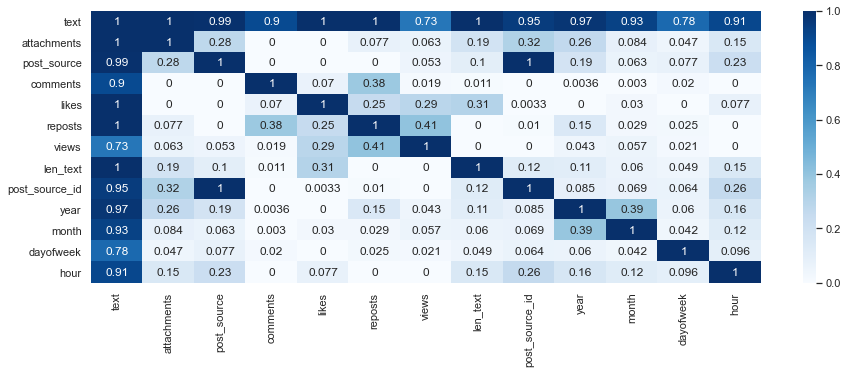

In [189]:
sns.heatmap(vk.phik_matrix(), annot=True, cmap='Blues')

Репосты высоко коррелируют с комментами и с просмотрами, лайки с длиной текста. Судя по всему, в определенные годы был бум постов с вложениями. Вложения также коррелируют с источником поста.

In [190]:
vk['metrics'] = (vk['likes'] / vk['views'])

Создали метрику, которая приблизительно оценивает популярность поста. В качестве такой метрики я выбрал конверсию лайков на просмотры, тк, на мой взгляд, такая практика лучше всего отражает популярность поста, насколько он нравится людям.

In [191]:
vk

text  \
artbazar_61     0                                 Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355   
                1    18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...   
                2                                                            концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽   
                3    День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...   
                4    Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 452  ❗Дорогие друзья! \nНаше сотрудничество с музеем "Шолохов-Центр" продолжается! \nМы рады пригласить вас на удивительный вечер, в течение которого вы сможете посмотреть сразу два (!) наших спектакля...   
                453  24 мая 2017 года в 12.00 в «Шолохов-Центре» Государственного музея-заповедника М.А. Шолохова в рамках культурно-просветительского проекта «Театр в музее» состоится спектакль «Нахаленок» по мотивам...   
                454                                                                                                                                                       "Шолохов-Центр" приглашает провести "Ночь в музее"   
                455  В «Шолохов-Центре» Государственного музея-заповедника М.А.Шолохова 28 апреля 2017 года состоялся финал серии интеллектуальных игр «Весенний филин-2017», в котором приняли участие 9 команд, успешно...   
                456  ИНТЕЛЛЕКТУАЛЬНЫЕ БОИ В "ШОЛОХОВ-ЦЕНТРЕ" \n\n28 апреля 2017 горда в «Шолохов-Центре» Государственного музея-заповедника М.А. Шолохова состоялся финал весенней серии интеллектуальных игр «Весенний ф...   

                     attachments post_source  comments  likes  reposts  \
artbazar_61     0              1          vk         2      6        2   
                1              1          vk         0     20        9   
                2              1          vk         0      2        2   
                3              1          vk         0      1        1   
                4              1          vk         0      1        1   
...                          ...         ...       ...    ...      ...   
sholokhovrostov 452            1          vk         0      2        0   
                453            1          vk         0      9        2   
                454            2          vk         0     37       12   
                455            1          vk         0      4        0   
                456            5          vk         0      6        0   

                      views  len_text  post_source_id  year  month  dayofweek  \
artbazar_61     0    1575.0       167               1  2022     11          3   
                1     624.0      1350               1  2023      2          2   
                2     372.0       138               1  2023      2          0   
                3     473.0      1055               1  2023      2          0   
                4     291.0       908               1  2023      2          0   
...                     ...       ...             ...   ...    ...        ...   
sholokhovrostov 452   221.0       778               1  2017      5     

In [192]:
vk.describe()

,attachments,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,metrics
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,1.726775,0.394793,13.238780,2.049742,668.698308,802.792929,0.777328,2020.392767,6.619289,2.626583,10.775808,0.023256
std,1.858198,1.903617,26.452102,4.277419,1079.419274,1040.447723,0.416061,1.615911,3.527304,1.763918,3.628393,0.018310
min,0.000000,0.000000,0.000000,0.000000,11.000000,1.000000,0.000000,2017.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,4.000000,0.000000,258.000000,208.000000,1.000000,2019.000000,4.000000,1.000000,8.000000,0.011070
50%,1.000000,0.000000,8.000000,1.000000,446.000000,527.000000,1.000000,2021.000000,6.000000,3.000000,10.000000,0.019469
75%,2.000000,0.000000,15.000000,2.000000,836.500000,986.000000,1.000000,2022.000000,10.000000,4.000000,13.000000,0.030963
max,10.000000,105.000000,2009.000000,114.000000,58951.000000,16087.000000,1.000000,2023.000000,12.000000,6.000000,23.000000,0.509511


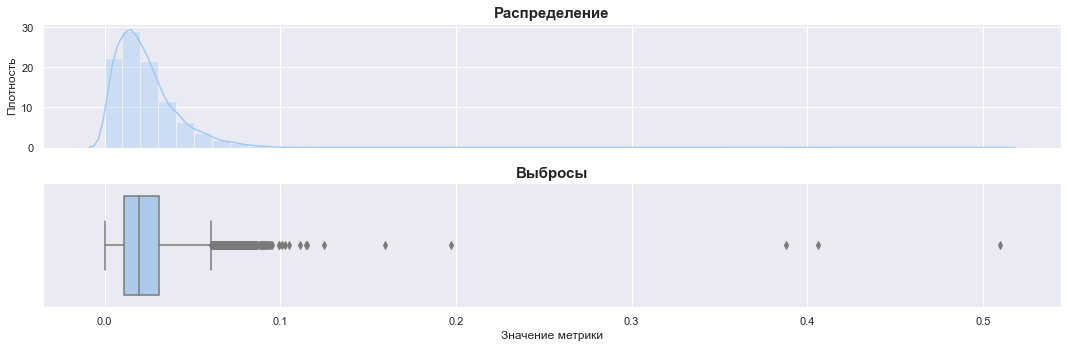

In [193]:
fig, ax = plt.subplots(2, 1, sharex=True)
sns.distplot(vk['metrics'], ax=ax[0])
ax[0].set_title('Распределение', fontweight='bold', fontsize=15)
ax[0].set_ylabel('Плотность')

sns.boxplot(vk['metrics'], ax=ax[1])
ax[1].set_title('Выбросы', fontweight='bold', fontsize=15)
ax[1].set_xlabel('Значение метрики')
plt.tight_layout()
plt.show()

Удалим выбросы. Наше распределение должно стать логнормальным. Я не буду удалять все выбросы. В качестве границы выберу 0,08, тк модель обучается лучше, если оставить часть выбросов (выявлено опытным путем). То есть удалены будут только самые крайние выбросы.

In [194]:
vk.drop(vk.loc[vk['metrics'] > 0.08].index, inplace=True)
vk.shape

(9798, 14)

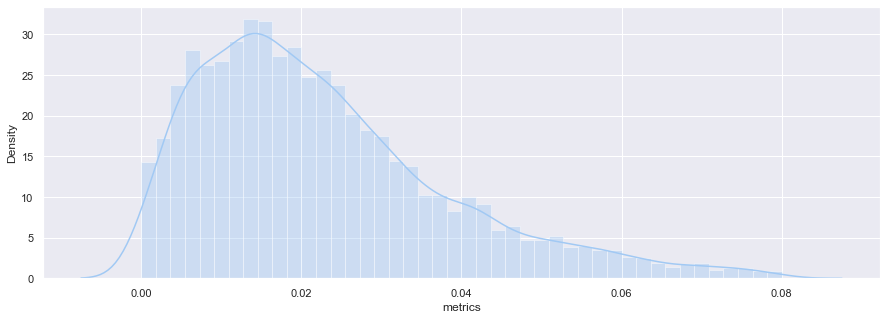

In [195]:
sns.distplot(vk['metrics'])
plt.show()

Нужно создать дополнительно метрику классификации. Пускай это будет бинарная классификация, где 1 - популярен, 0 - не популярен. В качестве порога популярности возьмем значение чуть выше среднего.

In [196]:
MEAN = vk['metrics'].mean() + 0.005
vk['metrics_classifier'] = vk['metrics'].apply(lambda x: 1 if x > MEAN else 0)
vk.head(5)

text  \
artbazar_61 0                               Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355   
            1  18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...   
            2                                                          концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽   
            3  День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...   
            4  Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...   

               attachments post_source  comments  likes  reposts   views  \
artbazar_61 0            1          vk         2      6        2  1575.0   
            1            1          vk         0     20        9   624.0   
            2            1          vk         0      2        2   372.0   
            3            1          vk         0      1        1   473.0   
            4            1          vk         0      1        1   291.0   

               len_text  post_source_id  year  month  dayofweek  hour  \
artbazar_61 0       167               1  2022     11          3    11   
            1      1350               1  2023      2          2    10   
            2       138               1  2023      2          0    13   
            3      1055               1  2023      2          0    12   
            4       908               1  2023      2          0    11   

                metrics  metrics_classifier  
artbazar_61 0  0.003810                   0  
            1  0.032051                   1  
            2  0.005376                   0  
            3  0.002114                   0  
            4  0.003436                   0

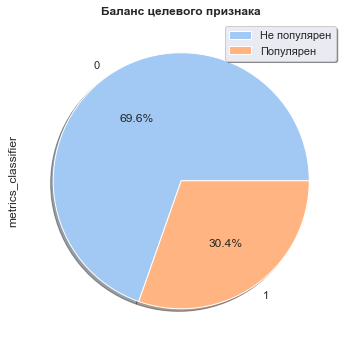

In [197]:
#Узнаем долю популярных постов
vk['metrics_classifier'].value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%')
plt.legend(['Не популярен', 'Популярен'], shadow=True)
plt.title('Баланс целевого признака', fontweight="bold")
plt.tight_layout()
plt.show()

Мы подготовили датафрейм. Сохраним его для новых исследований.

In [198]:
path = 'D:/vk/new_data/vk.csv'
vk.to_csv(path)

# Подготовка признаков

Теперь нам нужно подготовить посты к обучению.

In [199]:
pd.options.display.max_colwidth = 1000000 #Так выглядит пост до обработки
print(vk.loc[('artbazar_61', 4)][0])
pd.options.display.max_colwidth = 200

Большой концерт Ани Лорак «THE BEST» 

📆 26 Апреля в 19:00 
🚩 КСК Экспресс (ул. Закруткина, 67А)
🎫 Купить билет: https://vk.cc/cllmO2
💵 1500 — 7000 ₽

Все ранее купленные билеты действительны и обмену НЕ подлежат. 

Самая востребованная певица современности, Дива Ани Лорак, покажет новую, особенную концертную программу 

Название «THE BEST» говорит само за себя: концерт состоит из лучших хитов и всеми любимых песен, а также премьер из нового альбома артистки, релиз которого состоялся совсем недавно!
 
Голос Ани Лорак способен перевернуть сознание и вернуть веру в себя, а её искренность не оставляет равнодушным никого, ведь ощущение волшебства остается в сердце каждого зрителя, побывавшего на концерте!
 
Сочетание качественной музыки, только живого звука, завораживающих хореографических постановок и оригинальных костюмов, мощного голоса и невероятной красоты – всё это ждёт вас на предстоящих шоу!


In [200]:
def text_preprocessing(text):
    import re
    import nltk
    from nltk.corpus import stopwords
    import pymorphy2
    nltk.download('punkt')
    nltk.download('stopwords')
    
    text = re.sub(r'[^A-Za-zА-ЯЁа-яё-]+', ' ', text) #Убираем лишние знаки, оставляем только слова
    text = text.lower()
    
    tokens = nltk.word_tokenize(text, language='russian') #Токенизация
    
    stop_words1 = stopwords.words('russian') #Стоп-слова
    stop_words2 = stopwords.words('english')
    stop_words3 = stopwords.words('german')
    stop_words = stop_words1 + stop_words2 + stop_words3
    tokens = [item for item in tokens if item not in stop_words and len(item) > 1]
    
    lemmatizer = pymorphy2.MorphAnalyzer() #Лемматизация
    new_tokens = []
    for word in tokens:
        tag = lemmatizer.parse(word)[0].tag
        if lemmatizer.word_is_known(word) == False or 'Name' in tag or 'Geox' in tag or 'Surn' in tag or 'Patr' in tag or \
        'PRCL' in tag or 'INTJ' in tag or 'NPRO' in tag: #Убираем именные сущности и оставшиеся стоп-слова
            continue
        new_tokens.append(lemmatizer.normal_forms(word)[0])
        
    text = ' '.join(new_tokens) #Возвращаем текст
    return text

In [201]:
%%time
vk['text'] = vk['text'].parallel_apply(text_preprocessing)

CPU times: total: 7.83 s
Wall time: 3min 25s


In [202]:
pd.options.display.max_colwidth = 1000000 #Так после
print(vk.loc[('artbazar_61', 4)][0])
pd.options.display.max_colwidth = 200

большой концерт апрель экспресс ул купить билет ранее купить билет действительный обмен подлежать самый востребовать певица современность див показать новый особенный концертный программа название говорить сам концерт состоять хороший хит весь любимый песня премьер новый альбом артистка релиз который состояться недавно голос способный перевернуть сознание вернуть вера её искренность оставлять равнодушный ощущение волшебство оставаться сердце каждый зритель побывать концерт сочетание качественный музыка живой звук завораживать хореографический постановка оригинальный костюм мощный голос невероятный красота ждать предстоящий шоу


Как видим, наш препроцессор обработал весь датасет достаточно удачно. Время обработки занимает пару минут, благодаря параллельным вычислениям. Мы удалили все именные сущности, топонимы, стоп-слова, предлоги, местоимения, междометия и тп. Те слова, которые остались, несут максимальную информативность.

# Обучение

## Подготовка выборок

Создадим тренировочную и тестовую выборки с отношением 75%-25%. Отдельно выделим правильные ответы для задачи классификации (y_train_class, y_test_class) и для задачи регрессии (y_train, y_test). В качестве признаков оставим только текст, тк остальные признаки будут только создавать шум для нашей задачи обучения. Произведем векторизацию текстов двумя моделями (BOW и TF-IDF), по возможности будем стараться обучать модели на обоих наборах данных. 

In [42]:
X, y, y_class = vk['text'], vk['metrics'], vk['metrics_classifier'] #Создаем выборки
X_train, X_test, y_train, y_test, y_train_class, y_test_class = \
train_test_split(X, y, y_class, test_size=.25, random_state=RANDOM_STATE)
print(X_train.shape)
print(X_test.shape)

(7348,)
(2450,)


In [43]:
#BOW
vectorizer1 = CountVectorizer(min_df=10, dtype='float64')

X_train_bow = vectorizer1.fit_transform(X_train)
X_test_bow = vectorizer1.transform(X_test)
bow_features = vectorizer1.get_feature_names_out()

print(X_train_bow.shape)
print(X_test_bow.shape)
print(bow_features)

(7348, 4862)
(2450, 4862)
['абонемент' 'абсолютно' 'абсолютный' ... 'ящик' 'ёлка' 'ёлочный']


In [44]:
#TF-IDF
vectorizer2 = TfidfVectorizer(min_df=10)

X_train_tfidf = vectorizer2.fit_transform(X_train)
X_test_tfidf = vectorizer2.transform(X_test)
tfidf_features = vectorizer2.get_feature_names_out()

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(tfidf_features)

(7348, 4862)
(2450, 4862)
['абонемент' 'абсолютно' 'абсолютный' ... 'ящик' 'ёлка' 'ёлочный']


## Обучение регрессионных моделей

Для всех регрессионных моделей будем минимизировать метрику RMSE, потому что ее легко интерпретировать.

### Dummy

In [45]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train_bow, y_train)
dummy_predict = dummy_model.predict(X_test_bow)

rmse_dummy = (mean_squared_error(y_test, dummy_predict)) ** 0.5
print('RMSE dummy: ', rmse_dummy)

RMSE dummy:  0.015758631190404562


Мы выявили значение дамми регрессора, которое можно считать случайностью.

### LightGBM

In [46]:
#LightGBM model
params = {
    'max_depth' : [10, 13],
    'n_estimators' : [500, 1000]
}
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
model_lgbm = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', verbose=4)

In [47]:
%%time
#LightGBM with BOW
model_lgbm_bow = model_lgbm.fit(X_train_bow, y_train)

prediction_lgbm_bow = model_lgbm_bow.predict(X_test_bow)

rmse_lgbm_bow_cv = (-model_lgbm_bow.best_score_) ** .5

print('RMSE best CV: ', rmse_lgbm_bow_cv)
print('Best params: ', model_lgbm_bow.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.4s
[CV 2/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.4s
[CV 3/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.4s
[CV 4/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.4s
[CV 5/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.4s
[CV 1/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   0.7s
[CV 2/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   0.7s
[CV 3/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   0.7s
[CV 4/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   0.7s
[CV 5/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   0.7s
[CV 1/5] END ...max_depth=13, n_estimators=500;, score=-0.000 total time=   0.4s
[CV 2/5] END ...max_depth=13, n_estimators=500;, 

In [48]:
%%time
#LightGBM with TF-IDF
model_lgbm_tfidf = model_lgbm.fit(X_train_tfidf, y_train)

prediction_lgbm_tfidf = model_lgbm_tfidf.predict(X_test_tfidf)

rmse_lgbm_tfidf_cv = (-model_lgbm_tfidf.best_score_) ** .5

print('RMSE best CV: ', rmse_lgbm_tfidf_cv)
print('Best params: ', model_lgbm_tfidf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   1.8s
[CV 2/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   1.8s
[CV 3/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   1.8s
[CV 4/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   1.9s
[CV 5/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   1.7s
[CV 1/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   3.5s
[CV 2/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   3.3s
[CV 3/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   3.4s
[CV 4/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   3.4s
[CV 5/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   3.3s
[CV 1/5] END ...max_depth=13, n_estimators=500;, score=-0.000 total time=   2.4s
[CV 2/5] END ...max_depth=13, n_estimators=500;, 

Как видим, неплохие показатели выдала модель, обученная на признаках, закодированных BOW.

### Random Forest

In [49]:
%%time
def objective(trial):
    params = {
    'criterion' : trial.suggest_categorical('criterion', ['squared_error']),
    'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'max_depth' : trial.suggest_int('max_depth', 1, 15),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20, 2)
    }
    
    model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
    model_rf = model_rf.set_params(**params)
    model_rf.fit(X_train_bow, y_train)
    
    trial.set_user_attr(key="best_booster", value=model_rf)
    cross_valid = cross_val_score(model_rf, X_train_bow, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return ( - cross_valid) ** .5
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20, callbacks=[callback])
model_rf = study.user_attrs["best_booster"]
print('RMSE:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-19 21:17:46,463] A new study created in memory with name: no-name-f556fdc9-bc01-47ec-a6be-26ef9825de23
[I 2023-03-19 21:18:04,400] Trial 0 finished with value: 0.012417192738704222 and parameters: {'criterion': 'squared_error', 'n_estimators': 38, 'max_depth': 15, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.012417192738704222.
[I 2023-03-19 21:18:08,202] Trial 1 finished with value: 0.013111273397467985 and parameters: {'criterion': 'squared_error', 'n_estimators': 60, 'max_depth': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.012417192738704222.
[I 2023-03-19 21:18:11,318] Trial 2 finished with value: 0.012543530037095381 and parameters: {'criterion': 'squared_error', 'n_estimators': 6, 'max_depth': 13, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.012417192738704222.
[I 2023-03-19 21:18:12,917] Trial 3 finished with value: 0.013811547202456077 and parameters: {'criterion': 'squared_error', 'n_estimators': 71, 'max_depth': 1, 'min_samples_leaf

RMSE: 0.01234685826341355 с параметрами: {'criterion': 'squared_error', 'n_estimators': 97, 'max_depth': 15, 'min_samples_leaf': 10}
CPU times: total: 2min 26s
Wall time: 4min 36s


### CatBoost

Не буду обучать CatBoost на выборке TF-IDF, тк это очень дорого с точки зрения вычислительных ресурсов.

In [50]:
#CatBoost model
params = {
    'max_depth' : [10],
    'n_estimators' : [1000]
}
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE')
model_catboost = GridSearchCV(model_catboost, params, scoring='neg_mean_squared_error', verbose=4)

In [51]:
%%time
#CatBoost with BOW
model_catboost_bow = model_catboost.fit(X_train_bow, y_train)

prediction_catboost_bow = model_catboost_bow.predict(X_test_bow)

rmse_catboost_bow_cv = (-model_catboost_bow.best_score_) ** .5

print('RMSE best CV: ', rmse_catboost_bow_cv)
print('Best params: ', model_catboost_bow.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.054165
0:	learn: 0.0155441	total: 208ms	remaining: 3m 28s
1:	learn: 0.0153204	total: 262ms	remaining: 2m 10s
2:	learn: 0.0151213	total: 323ms	remaining: 1m 47s
3:	learn: 0.0149350	total: 377ms	remaining: 1m 33s
4:	learn: 0.0147758	total: 431ms	remaining: 1m 25s
5:	learn: 0.0146307	total: 494ms	remaining: 1m 21s
6:	learn: 0.0145051	total: 556ms	remaining: 1m 18s
7:	learn: 0.0143821	total: 617ms	remaining: 1m 16s
8:	learn: 0.0142682	total: 677ms	remaining: 1m 14s
9:	learn: 0.0141570	total: 740ms	remaining: 1m 13s
10:	learn: 0.0140600	total: 801ms	remaining: 1m 12s
11:	learn: 0.0139495	total: 862ms	remaining: 1m 11s
12:	learn: 0.0138677	total: 925ms	remaining: 1m 10s
13:	learn: 0.0137859	total: 984ms	remaining: 1m 9s
14:	learn: 0.0137175	total: 1.04s	remaining: 1m 8s
15:	learn: 0.0136272	total: 1.1s	remaining: 1m 7s
16:	learn: 0.0135516	total: 1.16s	remaining: 1m 7s
17:	learn: 0.0134865	total: 1.23s	remainin

160:	learn: 0.0118597	total: 9.96s	remaining: 51.9s
161:	learn: 0.0118438	total: 10s	remaining: 51.8s
162:	learn: 0.0118365	total: 10.1s	remaining: 51.8s
163:	learn: 0.0118246	total: 10.1s	remaining: 51.7s
164:	learn: 0.0118190	total: 10.2s	remaining: 51.6s
165:	learn: 0.0118089	total: 10.3s	remaining: 51.6s
166:	learn: 0.0118038	total: 10.3s	remaining: 51.5s
167:	learn: 0.0117989	total: 10.4s	remaining: 51.4s
168:	learn: 0.0117899	total: 10.5s	remaining: 51.4s
169:	learn: 0.0117819	total: 10.5s	remaining: 51.3s
170:	learn: 0.0117574	total: 10.6s	remaining: 51.2s
171:	learn: 0.0117552	total: 10.6s	remaining: 51.2s
172:	learn: 0.0117442	total: 10.7s	remaining: 51.1s
173:	learn: 0.0117386	total: 10.7s	remaining: 51s
174:	learn: 0.0117325	total: 10.8s	remaining: 50.9s
175:	learn: 0.0117260	total: 10.9s	remaining: 50.9s
176:	learn: 0.0117210	total: 10.9s	remaining: 50.8s
177:	learn: 0.0117195	total: 11s	remaining: 50.7s
178:	learn: 0.0117129	total: 11s	remaining: 50.6s
179:	learn: 0.011697

320:	learn: 0.0106789	total: 19.7s	remaining: 41.7s
321:	learn: 0.0106702	total: 19.8s	remaining: 41.7s
322:	learn: 0.0106666	total: 19.9s	remaining: 41.6s
323:	learn: 0.0106592	total: 19.9s	remaining: 41.6s
324:	learn: 0.0106492	total: 20s	remaining: 41.5s
325:	learn: 0.0106427	total: 20s	remaining: 41.4s
326:	learn: 0.0106396	total: 20.1s	remaining: 41.4s
327:	learn: 0.0106337	total: 20.1s	remaining: 41.3s
328:	learn: 0.0106278	total: 20.2s	remaining: 41.2s
329:	learn: 0.0106268	total: 20.3s	remaining: 41.1s
330:	learn: 0.0106232	total: 20.3s	remaining: 41.1s
331:	learn: 0.0106149	total: 20.4s	remaining: 41s
332:	learn: 0.0106117	total: 20.4s	remaining: 41s
333:	learn: 0.0106081	total: 20.5s	remaining: 40.9s
334:	learn: 0.0106071	total: 20.6s	remaining: 40.8s
335:	learn: 0.0105992	total: 20.6s	remaining: 40.8s
336:	learn: 0.0105919	total: 20.7s	remaining: 40.7s
337:	learn: 0.0105832	total: 20.8s	remaining: 40.7s
338:	learn: 0.0105774	total: 20.8s	remaining: 40.6s
339:	learn: 0.010573

480:	learn: 0.0099417	total: 29.6s	remaining: 31.9s
481:	learn: 0.0099410	total: 29.6s	remaining: 31.8s
482:	learn: 0.0099380	total: 29.7s	remaining: 31.8s
483:	learn: 0.0099308	total: 29.8s	remaining: 31.7s
484:	learn: 0.0099227	total: 29.8s	remaining: 31.7s
485:	learn: 0.0099180	total: 29.9s	remaining: 31.6s
486:	learn: 0.0099149	total: 29.9s	remaining: 31.5s
487:	learn: 0.0099100	total: 30s	remaining: 31.5s
488:	learn: 0.0099016	total: 30.1s	remaining: 31.4s
489:	learn: 0.0098952	total: 30.1s	remaining: 31.3s
490:	learn: 0.0098919	total: 30.2s	remaining: 31.3s
491:	learn: 0.0098884	total: 30.2s	remaining: 31.2s
492:	learn: 0.0098841	total: 30.3s	remaining: 31.2s
493:	learn: 0.0098833	total: 30.4s	remaining: 31.1s
494:	learn: 0.0098791	total: 30.4s	remaining: 31s
495:	learn: 0.0098751	total: 30.5s	remaining: 31s
496:	learn: 0.0098717	total: 30.5s	remaining: 30.9s
497:	learn: 0.0098698	total: 30.6s	remaining: 30.8s
498:	learn: 0.0098691	total: 30.7s	remaining: 30.8s
499:	learn: 0.0098

640:	learn: 0.0094137	total: 39.3s	remaining: 22s
641:	learn: 0.0094121	total: 39.4s	remaining: 21.9s
642:	learn: 0.0094102	total: 39.4s	remaining: 21.9s
643:	learn: 0.0094086	total: 39.5s	remaining: 21.8s
644:	learn: 0.0094053	total: 39.5s	remaining: 21.8s
645:	learn: 0.0093999	total: 39.6s	remaining: 21.7s
646:	learn: 0.0093960	total: 39.7s	remaining: 21.6s
647:	learn: 0.0093937	total: 39.7s	remaining: 21.6s
648:	learn: 0.0093900	total: 39.8s	remaining: 21.5s
649:	learn: 0.0093864	total: 39.8s	remaining: 21.4s
650:	learn: 0.0093847	total: 39.9s	remaining: 21.4s
651:	learn: 0.0093770	total: 40s	remaining: 21.3s
652:	learn: 0.0093757	total: 40s	remaining: 21.3s
653:	learn: 0.0093721	total: 40.1s	remaining: 21.2s
654:	learn: 0.0093713	total: 40.1s	remaining: 21.1s
655:	learn: 0.0093675	total: 40.2s	remaining: 21.1s
656:	learn: 0.0093619	total: 40.3s	remaining: 21s
657:	learn: 0.0093607	total: 40.3s	remaining: 21s
658:	learn: 0.0093551	total: 40.4s	remaining: 20.9s
659:	learn: 0.0093546	

800:	learn: 0.0089804	total: 49s	remaining: 12.2s
801:	learn: 0.0089761	total: 49.1s	remaining: 12.1s
802:	learn: 0.0089751	total: 49.1s	remaining: 12.1s
803:	learn: 0.0089730	total: 49.2s	remaining: 12s
804:	learn: 0.0089713	total: 49.3s	remaining: 11.9s
805:	learn: 0.0089666	total: 49.3s	remaining: 11.9s
806:	learn: 0.0089645	total: 49.4s	remaining: 11.8s
807:	learn: 0.0089620	total: 49.4s	remaining: 11.7s
808:	learn: 0.0089598	total: 49.5s	remaining: 11.7s
809:	learn: 0.0089580	total: 49.6s	remaining: 11.6s
810:	learn: 0.0089548	total: 49.6s	remaining: 11.6s
811:	learn: 0.0089521	total: 49.7s	remaining: 11.5s
812:	learn: 0.0089480	total: 49.7s	remaining: 11.4s
813:	learn: 0.0089475	total: 49.8s	remaining: 11.4s
814:	learn: 0.0089446	total: 49.8s	remaining: 11.3s
815:	learn: 0.0089432	total: 49.9s	remaining: 11.3s
816:	learn: 0.0089414	total: 50s	remaining: 11.2s
817:	learn: 0.0089368	total: 50s	remaining: 11.1s
818:	learn: 0.0089353	total: 50.1s	remaining: 11.1s
819:	learn: 0.008931

960:	learn: 0.0086214	total: 58.7s	remaining: 2.38s
961:	learn: 0.0086208	total: 58.8s	remaining: 2.32s
962:	learn: 0.0086179	total: 58.8s	remaining: 2.26s
963:	learn: 0.0086153	total: 58.9s	remaining: 2.2s
964:	learn: 0.0086141	total: 59s	remaining: 2.14s
965:	learn: 0.0086125	total: 59s	remaining: 2.08s
966:	learn: 0.0086102	total: 59.1s	remaining: 2.02s
967:	learn: 0.0086073	total: 59.1s	remaining: 1.96s
968:	learn: 0.0086058	total: 59.2s	remaining: 1.89s
969:	learn: 0.0086013	total: 59.3s	remaining: 1.83s
970:	learn: 0.0085966	total: 59.3s	remaining: 1.77s
971:	learn: 0.0085923	total: 59.4s	remaining: 1.71s
972:	learn: 0.0085877	total: 59.4s	remaining: 1.65s
973:	learn: 0.0085840	total: 59.5s	remaining: 1.59s
974:	learn: 0.0085836	total: 59.5s	remaining: 1.53s
975:	learn: 0.0085813	total: 59.6s	remaining: 1.47s
976:	learn: 0.0085792	total: 59.7s	remaining: 1.4s
977:	learn: 0.0085776	total: 59.7s	remaining: 1.34s
978:	learn: 0.0085750	total: 59.8s	remaining: 1.28s
979:	learn: 0.0085

123:	learn: 0.0121089	total: 5.77s	remaining: 40.8s
124:	learn: 0.0121051	total: 5.82s	remaining: 40.7s
125:	learn: 0.0120976	total: 5.87s	remaining: 40.7s
126:	learn: 0.0120943	total: 5.91s	remaining: 40.7s
127:	learn: 0.0120879	total: 5.96s	remaining: 40.6s
128:	learn: 0.0120822	total: 6.01s	remaining: 40.6s
129:	learn: 0.0120768	total: 6.06s	remaining: 40.5s
130:	learn: 0.0120712	total: 6.1s	remaining: 40.5s
131:	learn: 0.0120673	total: 6.15s	remaining: 40.5s
132:	learn: 0.0120618	total: 6.2s	remaining: 40.4s
133:	learn: 0.0120573	total: 6.25s	remaining: 40.4s
134:	learn: 0.0120546	total: 6.29s	remaining: 40.3s
135:	learn: 0.0120514	total: 6.34s	remaining: 40.3s
136:	learn: 0.0120465	total: 6.39s	remaining: 40.2s
137:	learn: 0.0120403	total: 6.43s	remaining: 40.2s
138:	learn: 0.0120342	total: 6.48s	remaining: 40.2s
139:	learn: 0.0120306	total: 6.53s	remaining: 40.1s
140:	learn: 0.0120294	total: 6.58s	remaining: 40.1s
141:	learn: 0.0120251	total: 6.63s	remaining: 40s
142:	learn: 0.01

282:	learn: 0.0109236	total: 13.4s	remaining: 33.9s
283:	learn: 0.0109127	total: 13.4s	remaining: 33.9s
284:	learn: 0.0109010	total: 13.5s	remaining: 33.9s
285:	learn: 0.0108940	total: 13.5s	remaining: 33.8s
286:	learn: 0.0108858	total: 13.6s	remaining: 33.8s
287:	learn: 0.0108768	total: 13.6s	remaining: 33.7s
288:	learn: 0.0108729	total: 13.7s	remaining: 33.7s
289:	learn: 0.0108708	total: 13.7s	remaining: 33.6s
290:	learn: 0.0108658	total: 13.8s	remaining: 33.6s
291:	learn: 0.0108601	total: 13.8s	remaining: 33.5s
292:	learn: 0.0108567	total: 13.9s	remaining: 33.5s
293:	learn: 0.0108507	total: 13.9s	remaining: 33.4s
294:	learn: 0.0108484	total: 14s	remaining: 33.4s
295:	learn: 0.0108432	total: 14s	remaining: 33.3s
296:	learn: 0.0108386	total: 14.1s	remaining: 33.3s
297:	learn: 0.0108361	total: 14.1s	remaining: 33.2s
298:	learn: 0.0108287	total: 14.2s	remaining: 33.2s
299:	learn: 0.0108246	total: 14.2s	remaining: 33.2s
300:	learn: 0.0108160	total: 14.3s	remaining: 33.1s
301:	learn: 0.01

442:	learn: 0.0101257	total: 21.1s	remaining: 26.5s
443:	learn: 0.0101226	total: 21.1s	remaining: 26.5s
444:	learn: 0.0101215	total: 21.2s	remaining: 26.4s
445:	learn: 0.0101178	total: 21.2s	remaining: 26.4s
446:	learn: 0.0101136	total: 21.3s	remaining: 26.3s
447:	learn: 0.0101100	total: 21.3s	remaining: 26.3s
448:	learn: 0.0101072	total: 21.4s	remaining: 26.2s
449:	learn: 0.0101042	total: 21.4s	remaining: 26.2s
450:	learn: 0.0100983	total: 21.5s	remaining: 26.1s
451:	learn: 0.0100937	total: 21.5s	remaining: 26.1s
452:	learn: 0.0100925	total: 21.6s	remaining: 26.1s
453:	learn: 0.0100915	total: 21.6s	remaining: 26s
454:	learn: 0.0100885	total: 21.7s	remaining: 26s
455:	learn: 0.0100800	total: 21.7s	remaining: 25.9s
456:	learn: 0.0100793	total: 21.8s	remaining: 25.9s
457:	learn: 0.0100753	total: 21.8s	remaining: 25.8s
458:	learn: 0.0100704	total: 21.9s	remaining: 25.8s
459:	learn: 0.0100679	total: 21.9s	remaining: 25.7s
460:	learn: 0.0100653	total: 22s	remaining: 25.7s
461:	learn: 0.0100

602:	learn: 0.0095882	total: 28.8s	remaining: 19s
603:	learn: 0.0095871	total: 28.9s	remaining: 18.9s
604:	learn: 0.0095862	total: 28.9s	remaining: 18.9s
605:	learn: 0.0095848	total: 28.9s	remaining: 18.8s
606:	learn: 0.0095839	total: 29s	remaining: 18.8s
607:	learn: 0.0095800	total: 29s	remaining: 18.7s
608:	learn: 0.0095743	total: 29.1s	remaining: 18.7s
609:	learn: 0.0095728	total: 29.1s	remaining: 18.6s
610:	learn: 0.0095723	total: 29.2s	remaining: 18.6s
611:	learn: 0.0095701	total: 29.2s	remaining: 18.5s
612:	learn: 0.0095665	total: 29.3s	remaining: 18.5s
613:	learn: 0.0095634	total: 29.3s	remaining: 18.4s
614:	learn: 0.0095629	total: 29.4s	remaining: 18.4s
615:	learn: 0.0095606	total: 29.4s	remaining: 18.3s
616:	learn: 0.0095572	total: 29.5s	remaining: 18.3s
617:	learn: 0.0095540	total: 29.5s	remaining: 18.2s
618:	learn: 0.0095512	total: 29.6s	remaining: 18.2s
619:	learn: 0.0095490	total: 29.6s	remaining: 18.1s
620:	learn: 0.0095471	total: 29.7s	remaining: 18.1s
621:	learn: 0.0095

762:	learn: 0.0091682	total: 36.4s	remaining: 11.3s
763:	learn: 0.0091670	total: 36.5s	remaining: 11.3s
764:	learn: 0.0091632	total: 36.5s	remaining: 11.2s
765:	learn: 0.0091624	total: 36.6s	remaining: 11.2s
766:	learn: 0.0091566	total: 36.6s	remaining: 11.1s
767:	learn: 0.0091513	total: 36.7s	remaining: 11.1s
768:	learn: 0.0091506	total: 36.7s	remaining: 11s
769:	learn: 0.0091470	total: 36.8s	remaining: 11s
770:	learn: 0.0091467	total: 36.8s	remaining: 10.9s
771:	learn: 0.0091437	total: 36.9s	remaining: 10.9s
772:	learn: 0.0091433	total: 36.9s	remaining: 10.8s
773:	learn: 0.0091410	total: 37s	remaining: 10.8s
774:	learn: 0.0091375	total: 37s	remaining: 10.7s
775:	learn: 0.0091340	total: 37s	remaining: 10.7s
776:	learn: 0.0091337	total: 37.1s	remaining: 10.6s
777:	learn: 0.0091318	total: 37.1s	remaining: 10.6s
778:	learn: 0.0091284	total: 37.2s	remaining: 10.5s
779:	learn: 0.0091245	total: 37.2s	remaining: 10.5s
780:	learn: 0.0091220	total: 37.3s	remaining: 10.5s
781:	learn: 0.0091185	

922:	learn: 0.0088241	total: 44.1s	remaining: 3.67s
923:	learn: 0.0088237	total: 44.1s	remaining: 3.63s
924:	learn: 0.0088224	total: 44.2s	remaining: 3.58s
925:	learn: 0.0088206	total: 44.2s	remaining: 3.53s
926:	learn: 0.0088189	total: 44.2s	remaining: 3.48s
927:	learn: 0.0088165	total: 44.3s	remaining: 3.44s
928:	learn: 0.0088148	total: 44.3s	remaining: 3.39s
929:	learn: 0.0088130	total: 44.4s	remaining: 3.34s
930:	learn: 0.0088113	total: 44.4s	remaining: 3.29s
931:	learn: 0.0088079	total: 44.5s	remaining: 3.25s
932:	learn: 0.0088065	total: 44.5s	remaining: 3.2s
933:	learn: 0.0088040	total: 44.6s	remaining: 3.15s
934:	learn: 0.0088019	total: 44.6s	remaining: 3.1s
935:	learn: 0.0088005	total: 44.7s	remaining: 3.05s
936:	learn: 0.0087982	total: 44.7s	remaining: 3.01s
937:	learn: 0.0087943	total: 44.8s	remaining: 2.96s
938:	learn: 0.0087910	total: 44.8s	remaining: 2.91s
939:	learn: 0.0087901	total: 44.9s	remaining: 2.86s
940:	learn: 0.0087898	total: 44.9s	remaining: 2.82s
941:	learn: 0.

82:	learn: 0.0124054	total: 4.87s	remaining: 53.8s
83:	learn: 0.0124009	total: 4.93s	remaining: 53.8s
84:	learn: 0.0123935	total: 4.99s	remaining: 53.7s
85:	learn: 0.0123864	total: 5.05s	remaining: 53.6s
86:	learn: 0.0123834	total: 5.11s	remaining: 53.6s
87:	learn: 0.0123798	total: 5.17s	remaining: 53.5s
88:	learn: 0.0123733	total: 5.22s	remaining: 53.5s
89:	learn: 0.0123536	total: 5.28s	remaining: 53.4s
90:	learn: 0.0123504	total: 5.34s	remaining: 53.4s
91:	learn: 0.0123439	total: 5.4s	remaining: 53.3s
92:	learn: 0.0123388	total: 5.46s	remaining: 53.2s
93:	learn: 0.0123292	total: 5.52s	remaining: 53.2s
94:	learn: 0.0123155	total: 5.58s	remaining: 53.1s
95:	learn: 0.0123099	total: 5.63s	remaining: 53.1s
96:	learn: 0.0123057	total: 5.69s	remaining: 53s
97:	learn: 0.0123022	total: 5.75s	remaining: 53s
98:	learn: 0.0122992	total: 5.81s	remaining: 52.9s
99:	learn: 0.0122935	total: 5.87s	remaining: 52.8s
100:	learn: 0.0122879	total: 5.93s	remaining: 52.8s
101:	learn: 0.0122821	total: 5.99s	

242:	learn: 0.0112450	total: 14.4s	remaining: 44.8s
243:	learn: 0.0112344	total: 14.5s	remaining: 44.8s
244:	learn: 0.0112293	total: 14.5s	remaining: 44.7s
245:	learn: 0.0112200	total: 14.6s	remaining: 44.7s
246:	learn: 0.0112125	total: 14.6s	remaining: 44.6s
247:	learn: 0.0112041	total: 14.7s	remaining: 44.6s
248:	learn: 0.0111973	total: 14.8s	remaining: 44.5s
249:	learn: 0.0111889	total: 14.8s	remaining: 44.4s
250:	learn: 0.0111819	total: 14.9s	remaining: 44.4s
251:	learn: 0.0111740	total: 14.9s	remaining: 44.3s
252:	learn: 0.0111678	total: 15s	remaining: 44.3s
253:	learn: 0.0111554	total: 15.1s	remaining: 44.2s
254:	learn: 0.0111478	total: 15.1s	remaining: 44.2s
255:	learn: 0.0111373	total: 15.2s	remaining: 44.1s
256:	learn: 0.0111313	total: 15.2s	remaining: 44s
257:	learn: 0.0111233	total: 15.3s	remaining: 44s
258:	learn: 0.0111181	total: 15.4s	remaining: 43.9s
259:	learn: 0.0111157	total: 15.4s	remaining: 43.9s
260:	learn: 0.0111099	total: 15.5s	remaining: 43.8s
261:	learn: 0.0111

402:	learn: 0.0103452	total: 24.1s	remaining: 35.7s
403:	learn: 0.0103406	total: 24.1s	remaining: 35.6s
404:	learn: 0.0103375	total: 24.2s	remaining: 35.6s
405:	learn: 0.0103311	total: 24.3s	remaining: 35.5s
406:	learn: 0.0103290	total: 24.3s	remaining: 35.4s
407:	learn: 0.0103230	total: 24.4s	remaining: 35.4s
408:	learn: 0.0103216	total: 24.5s	remaining: 35.3s
409:	learn: 0.0103137	total: 24.5s	remaining: 35.3s
410:	learn: 0.0103029	total: 24.6s	remaining: 35.2s
411:	learn: 0.0102965	total: 24.6s	remaining: 35.2s
412:	learn: 0.0102915	total: 24.7s	remaining: 35.1s
413:	learn: 0.0102851	total: 24.8s	remaining: 35.1s
414:	learn: 0.0102803	total: 24.8s	remaining: 35s
415:	learn: 0.0102771	total: 24.9s	remaining: 34.9s
416:	learn: 0.0102742	total: 25s	remaining: 34.9s
417:	learn: 0.0102683	total: 25s	remaining: 34.8s
418:	learn: 0.0102616	total: 25.1s	remaining: 34.8s
419:	learn: 0.0102543	total: 25.1s	remaining: 34.7s
420:	learn: 0.0102519	total: 25.2s	remaining: 34.7s
421:	learn: 0.0102

562:	learn: 0.0097299	total: 34s	remaining: 26.4s
563:	learn: 0.0097271	total: 34.1s	remaining: 26.4s
564:	learn: 0.0097230	total: 34.2s	remaining: 26.3s
565:	learn: 0.0097198	total: 34.2s	remaining: 26.2s
566:	learn: 0.0097184	total: 34.3s	remaining: 26.2s
567:	learn: 0.0097160	total: 34.3s	remaining: 26.1s
568:	learn: 0.0097149	total: 34.4s	remaining: 26.1s
569:	learn: 0.0097119	total: 34.5s	remaining: 26s
570:	learn: 0.0097049	total: 34.5s	remaining: 25.9s
571:	learn: 0.0097002	total: 34.6s	remaining: 25.9s
572:	learn: 0.0096960	total: 34.7s	remaining: 25.8s
573:	learn: 0.0096918	total: 34.7s	remaining: 25.8s
574:	learn: 0.0096874	total: 34.8s	remaining: 25.7s
575:	learn: 0.0096866	total: 34.8s	remaining: 25.6s
576:	learn: 0.0096833	total: 34.9s	remaining: 25.6s
577:	learn: 0.0096809	total: 35s	remaining: 25.5s
578:	learn: 0.0096741	total: 35s	remaining: 25.5s
579:	learn: 0.0096688	total: 35.1s	remaining: 25.4s
580:	learn: 0.0096649	total: 35.1s	remaining: 25.3s
581:	learn: 0.009662

722:	learn: 0.0092355	total: 44.1s	remaining: 16.9s
723:	learn: 0.0092338	total: 44.2s	remaining: 16.8s
724:	learn: 0.0092289	total: 44.2s	remaining: 16.8s
725:	learn: 0.0092268	total: 44.3s	remaining: 16.7s
726:	learn: 0.0092252	total: 44.4s	remaining: 16.7s
727:	learn: 0.0092204	total: 44.4s	remaining: 16.6s
728:	learn: 0.0092149	total: 44.5s	remaining: 16.5s
729:	learn: 0.0092144	total: 44.5s	remaining: 16.5s
730:	learn: 0.0092097	total: 44.6s	remaining: 16.4s
731:	learn: 0.0092055	total: 44.7s	remaining: 16.4s
732:	learn: 0.0092014	total: 44.7s	remaining: 16.3s
733:	learn: 0.0091978	total: 44.8s	remaining: 16.2s
734:	learn: 0.0091938	total: 44.9s	remaining: 16.2s
735:	learn: 0.0091928	total: 44.9s	remaining: 16.1s
736:	learn: 0.0091885	total: 45s	remaining: 16s
737:	learn: 0.0091832	total: 45s	remaining: 16s
738:	learn: 0.0091821	total: 45.1s	remaining: 15.9s
739:	learn: 0.0091783	total: 45.2s	remaining: 15.9s
740:	learn: 0.0091757	total: 45.2s	remaining: 15.8s
741:	learn: 0.009174

882:	learn: 0.0088217	total: 54.3s	remaining: 7.19s
883:	learn: 0.0088198	total: 54.3s	remaining: 7.13s
884:	learn: 0.0088180	total: 54.4s	remaining: 7.07s
885:	learn: 0.0088164	total: 54.5s	remaining: 7.01s
886:	learn: 0.0088152	total: 54.5s	remaining: 6.95s
887:	learn: 0.0088118	total: 54.6s	remaining: 6.89s
888:	learn: 0.0088114	total: 54.7s	remaining: 6.83s
889:	learn: 0.0088091	total: 54.7s	remaining: 6.76s
890:	learn: 0.0088080	total: 54.8s	remaining: 6.7s
891:	learn: 0.0088060	total: 54.9s	remaining: 6.64s
892:	learn: 0.0088035	total: 54.9s	remaining: 6.58s
893:	learn: 0.0087999	total: 55s	remaining: 6.52s
894:	learn: 0.0087980	total: 55.1s	remaining: 6.46s
895:	learn: 0.0087951	total: 55.1s	remaining: 6.4s
896:	learn: 0.0087931	total: 55.2s	remaining: 6.34s
897:	learn: 0.0087876	total: 55.2s	remaining: 6.28s
898:	learn: 0.0087827	total: 55.3s	remaining: 6.21s
899:	learn: 0.0087788	total: 55.4s	remaining: 6.15s
900:	learn: 0.0087767	total: 55.4s	remaining: 6.09s
901:	learn: 0.00

41:	learn: 0.0128038	total: 2.88s	remaining: 1m 5s
42:	learn: 0.0127861	total: 2.95s	remaining: 1m 5s
43:	learn: 0.0127708	total: 3.01s	remaining: 1m 5s
44:	learn: 0.0127573	total: 3.08s	remaining: 1m 5s
45:	learn: 0.0127437	total: 3.15s	remaining: 1m 5s
46:	learn: 0.0127248	total: 3.22s	remaining: 1m 5s
47:	learn: 0.0127167	total: 3.28s	remaining: 1m 5s
48:	learn: 0.0127027	total: 3.35s	remaining: 1m 5s
49:	learn: 0.0126925	total: 3.42s	remaining: 1m 5s
50:	learn: 0.0126773	total: 3.49s	remaining: 1m 4s
51:	learn: 0.0126624	total: 3.56s	remaining: 1m 4s
52:	learn: 0.0126535	total: 3.63s	remaining: 1m 4s
53:	learn: 0.0126437	total: 3.69s	remaining: 1m 4s
54:	learn: 0.0126313	total: 3.76s	remaining: 1m 4s
55:	learn: 0.0126230	total: 3.83s	remaining: 1m 4s
56:	learn: 0.0126124	total: 3.9s	remaining: 1m 4s
57:	learn: 0.0126039	total: 3.97s	remaining: 1m 4s
58:	learn: 0.0125944	total: 4.04s	remaining: 1m 4s
59:	learn: 0.0125877	total: 4.11s	remaining: 1m 4s
60:	learn: 0.0125772	total: 4.17

203:	learn: 0.0115656	total: 13.8s	remaining: 53.9s
204:	learn: 0.0115543	total: 13.9s	remaining: 53.8s
205:	learn: 0.0115395	total: 13.9s	remaining: 53.8s
206:	learn: 0.0115278	total: 14s	remaining: 53.7s
207:	learn: 0.0115218	total: 14.1s	remaining: 53.6s
208:	learn: 0.0115083	total: 14.1s	remaining: 53.6s
209:	learn: 0.0114989	total: 14.2s	remaining: 53.5s
210:	learn: 0.0114872	total: 14.3s	remaining: 53.4s
211:	learn: 0.0114853	total: 14.3s	remaining: 53.3s
212:	learn: 0.0114834	total: 14.4s	remaining: 53.3s
213:	learn: 0.0114771	total: 14.5s	remaining: 53.2s
214:	learn: 0.0114752	total: 14.6s	remaining: 53.1s
215:	learn: 0.0114736	total: 14.6s	remaining: 53.1s
216:	learn: 0.0114697	total: 14.7s	remaining: 53s
217:	learn: 0.0114679	total: 14.8s	remaining: 52.9s
218:	learn: 0.0114665	total: 14.8s	remaining: 52.8s
219:	learn: 0.0114550	total: 14.9s	remaining: 52.8s
220:	learn: 0.0114494	total: 15s	remaining: 52.7s
221:	learn: 0.0114478	total: 15s	remaining: 52.6s
222:	learn: 0.011442

362:	learn: 0.0105874	total: 24.5s	remaining: 43s
363:	learn: 0.0105762	total: 24.6s	remaining: 43s
364:	learn: 0.0105720	total: 24.7s	remaining: 42.9s
365:	learn: 0.0105665	total: 24.7s	remaining: 42.9s
366:	learn: 0.0105620	total: 24.8s	remaining: 42.8s
367:	learn: 0.0105605	total: 24.9s	remaining: 42.7s
368:	learn: 0.0105534	total: 24.9s	remaining: 42.7s
369:	learn: 0.0105443	total: 25s	remaining: 42.6s
370:	learn: 0.0105354	total: 25.1s	remaining: 42.5s
371:	learn: 0.0105306	total: 25.1s	remaining: 42.4s
372:	learn: 0.0105287	total: 25.2s	remaining: 42.4s
373:	learn: 0.0105221	total: 25.3s	remaining: 42.3s
374:	learn: 0.0105183	total: 25.3s	remaining: 42.2s
375:	learn: 0.0105133	total: 25.4s	remaining: 42.2s
376:	learn: 0.0105124	total: 25.5s	remaining: 42.1s
377:	learn: 0.0105083	total: 25.5s	remaining: 42s
378:	learn: 0.0105064	total: 25.6s	remaining: 42s
379:	learn: 0.0105006	total: 25.7s	remaining: 41.9s
380:	learn: 0.0104927	total: 25.8s	remaining: 41.8s
381:	learn: 0.0104872	

523:	learn: 0.0099070	total: 35.7s	remaining: 32.4s
524:	learn: 0.0099063	total: 35.7s	remaining: 32.3s
525:	learn: 0.0099047	total: 35.8s	remaining: 32.3s
526:	learn: 0.0099000	total: 35.9s	remaining: 32.2s
527:	learn: 0.0098965	total: 35.9s	remaining: 32.1s
528:	learn: 0.0098909	total: 36s	remaining: 32.1s
529:	learn: 0.0098865	total: 36.1s	remaining: 32s
530:	learn: 0.0098858	total: 36.1s	remaining: 31.9s
531:	learn: 0.0098820	total: 36.2s	remaining: 31.9s
532:	learn: 0.0098806	total: 36.3s	remaining: 31.8s
533:	learn: 0.0098781	total: 36.4s	remaining: 31.7s
534:	learn: 0.0098774	total: 36.4s	remaining: 31.7s
535:	learn: 0.0098743	total: 36.5s	remaining: 31.6s
536:	learn: 0.0098711	total: 36.6s	remaining: 31.5s
537:	learn: 0.0098705	total: 36.6s	remaining: 31.5s
538:	learn: 0.0098699	total: 36.7s	remaining: 31.4s
539:	learn: 0.0098685	total: 36.8s	remaining: 31.3s
540:	learn: 0.0098650	total: 36.8s	remaining: 31.3s
541:	learn: 0.0098636	total: 36.9s	remaining: 31.2s
542:	learn: 0.00

682:	learn: 0.0094339	total: 47s	remaining: 21.8s
683:	learn: 0.0094302	total: 47.1s	remaining: 21.8s
684:	learn: 0.0094269	total: 47.2s	remaining: 21.7s
685:	learn: 0.0094224	total: 47.3s	remaining: 21.6s
686:	learn: 0.0094190	total: 47.3s	remaining: 21.6s
687:	learn: 0.0094159	total: 47.4s	remaining: 21.5s
688:	learn: 0.0094124	total: 47.5s	remaining: 21.4s
689:	learn: 0.0094108	total: 47.6s	remaining: 21.4s
690:	learn: 0.0094074	total: 47.6s	remaining: 21.3s
691:	learn: 0.0094043	total: 47.7s	remaining: 21.2s
692:	learn: 0.0094007	total: 47.8s	remaining: 21.2s
693:	learn: 0.0093995	total: 47.8s	remaining: 21.1s
694:	learn: 0.0093965	total: 47.9s	remaining: 21s
695:	learn: 0.0093929	total: 48s	remaining: 21s
696:	learn: 0.0093924	total: 48.1s	remaining: 20.9s
697:	learn: 0.0093895	total: 48.1s	remaining: 20.8s
698:	learn: 0.0093885	total: 48.2s	remaining: 20.8s
699:	learn: 0.0093855	total: 48.3s	remaining: 20.7s
700:	learn: 0.0093827	total: 48.3s	remaining: 20.6s
701:	learn: 0.009378

841:	learn: 0.0089974	total: 58.9s	remaining: 11s
842:	learn: 0.0089935	total: 58.9s	remaining: 11s
843:	learn: 0.0089905	total: 59s	remaining: 10.9s
844:	learn: 0.0089890	total: 59.1s	remaining: 10.8s
845:	learn: 0.0089859	total: 59.2s	remaining: 10.8s
846:	learn: 0.0089827	total: 59.2s	remaining: 10.7s
847:	learn: 0.0089812	total: 59.3s	remaining: 10.6s
848:	learn: 0.0089799	total: 59.4s	remaining: 10.6s
849:	learn: 0.0089785	total: 59.4s	remaining: 10.5s
850:	learn: 0.0089775	total: 59.5s	remaining: 10.4s
851:	learn: 0.0089726	total: 59.6s	remaining: 10.4s
852:	learn: 0.0089708	total: 59.7s	remaining: 10.3s
853:	learn: 0.0089685	total: 59.7s	remaining: 10.2s
854:	learn: 0.0089668	total: 59.8s	remaining: 10.1s
855:	learn: 0.0089642	total: 59.9s	remaining: 10.1s
856:	learn: 0.0089605	total: 59.9s	remaining: 10s
857:	learn: 0.0089601	total: 1m	remaining: 9.93s
858:	learn: 0.0089590	total: 1m	remaining: 9.86s
859:	learn: 0.0089571	total: 1m	remaining: 9.79s
860:	learn: 0.0089558	total: 

[CV 4/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time= 1.2min
Learning rate set to 0.054166
0:	learn: 0.0155131	total: 68.8ms	remaining: 1m 8s
1:	learn: 0.0152949	total: 138ms	remaining: 1m 8s
2:	learn: 0.0151017	total: 206ms	remaining: 1m 8s
3:	learn: 0.0149271	total: 275ms	remaining: 1m 8s
4:	learn: 0.0147863	total: 344ms	remaining: 1m 8s
5:	learn: 0.0146341	total: 415ms	remaining: 1m 8s
6:	learn: 0.0144827	total: 484ms	remaining: 1m 8s
7:	learn: 0.0143495	total: 554ms	remaining: 1m 8s
8:	learn: 0.0142325	total: 624ms	remaining: 1m 8s
9:	learn: 0.0141299	total: 693ms	remaining: 1m 8s
10:	learn: 0.0140289	total: 762ms	remaining: 1m 8s
11:	learn: 0.0139253	total: 835ms	remaining: 1m 8s
12:	learn: 0.0138467	total: 904ms	remaining: 1m 8s
13:	learn: 0.0137644	total: 973ms	remaining: 1m 8s
14:	learn: 0.0136850	total: 1.04s	remaining: 1m 8s
15:	learn: 0.0136035	total: 1.11s	remaining: 1m 8s
16:	learn: 0.0135462	total: 1.18s	remaining: 1m 8s
17:	learn: 0.0134843	total: 1.2

162:	learn: 0.0118396	total: 11.1s	remaining: 57.1s
163:	learn: 0.0118332	total: 11.2s	remaining: 57.1s
164:	learn: 0.0118321	total: 11.3s	remaining: 57s
165:	learn: 0.0118235	total: 11.3s	remaining: 56.9s
166:	learn: 0.0118143	total: 11.4s	remaining: 56.8s
167:	learn: 0.0118008	total: 11.5s	remaining: 56.8s
168:	learn: 0.0117999	total: 11.5s	remaining: 56.7s
169:	learn: 0.0117944	total: 11.6s	remaining: 56.6s
170:	learn: 0.0117880	total: 11.7s	remaining: 56.6s
171:	learn: 0.0117785	total: 11.7s	remaining: 56.5s
172:	learn: 0.0117719	total: 11.8s	remaining: 56.5s
173:	learn: 0.0117629	total: 11.9s	remaining: 56.4s
174:	learn: 0.0117527	total: 11.9s	remaining: 56.3s
175:	learn: 0.0117440	total: 12s	remaining: 56.3s
176:	learn: 0.0117364	total: 12.1s	remaining: 56.2s
177:	learn: 0.0117297	total: 12.2s	remaining: 56.1s
178:	learn: 0.0117279	total: 12.2s	remaining: 56.1s
179:	learn: 0.0117175	total: 12.3s	remaining: 56s
180:	learn: 0.0117106	total: 12.4s	remaining: 55.9s
181:	learn: 0.0116

324:	learn: 0.0106571	total: 22.2s	remaining: 46.1s
325:	learn: 0.0106503	total: 22.3s	remaining: 46s
326:	learn: 0.0106477	total: 22.3s	remaining: 46s
327:	learn: 0.0106384	total: 22.4s	remaining: 45.9s
328:	learn: 0.0106277	total: 22.5s	remaining: 45.9s
329:	learn: 0.0106165	total: 22.6s	remaining: 45.8s
330:	learn: 0.0106124	total: 22.6s	remaining: 45.7s
331:	learn: 0.0106035	total: 22.7s	remaining: 45.7s
332:	learn: 0.0105938	total: 22.8s	remaining: 45.6s
333:	learn: 0.0105859	total: 22.9s	remaining: 45.6s
334:	learn: 0.0105805	total: 22.9s	remaining: 45.5s
335:	learn: 0.0105771	total: 23s	remaining: 45.4s
336:	learn: 0.0105723	total: 23.1s	remaining: 45.4s
337:	learn: 0.0105658	total: 23.1s	remaining: 45.3s
338:	learn: 0.0105631	total: 23.2s	remaining: 45.2s
339:	learn: 0.0105563	total: 23.3s	remaining: 45.2s
340:	learn: 0.0105478	total: 23.3s	remaining: 45.1s
341:	learn: 0.0105368	total: 23.4s	remaining: 45s
342:	learn: 0.0105335	total: 23.5s	remaining: 45s
343:	learn: 0.0105298	

484:	learn: 0.0099073	total: 33.2s	remaining: 35.2s
485:	learn: 0.0099059	total: 33.3s	remaining: 35.2s
486:	learn: 0.0098985	total: 33.3s	remaining: 35.1s
487:	learn: 0.0098929	total: 33.4s	remaining: 35s
488:	learn: 0.0098891	total: 33.5s	remaining: 35s
489:	learn: 0.0098860	total: 33.5s	remaining: 34.9s
490:	learn: 0.0098835	total: 33.6s	remaining: 34.8s
491:	learn: 0.0098829	total: 33.7s	remaining: 34.8s
492:	learn: 0.0098815	total: 33.7s	remaining: 34.7s
493:	learn: 0.0098763	total: 33.8s	remaining: 34.6s
494:	learn: 0.0098729	total: 33.9s	remaining: 34.6s
495:	learn: 0.0098697	total: 33.9s	remaining: 34.5s
496:	learn: 0.0098617	total: 34s	remaining: 34.4s
497:	learn: 0.0098570	total: 34.1s	remaining: 34.4s
498:	learn: 0.0098551	total: 34.2s	remaining: 34.3s
499:	learn: 0.0098544	total: 34.2s	remaining: 34.2s
500:	learn: 0.0098497	total: 34.3s	remaining: 34.2s
501:	learn: 0.0098482	total: 34.4s	remaining: 34.1s
502:	learn: 0.0098451	total: 34.4s	remaining: 34s
503:	learn: 0.009839

645:	learn: 0.0093931	total: 44.4s	remaining: 24.3s
646:	learn: 0.0093907	total: 44.4s	remaining: 24.2s
647:	learn: 0.0093880	total: 44.5s	remaining: 24.2s
648:	learn: 0.0093855	total: 44.6s	remaining: 24.1s
649:	learn: 0.0093835	total: 44.6s	remaining: 24s
650:	learn: 0.0093814	total: 44.7s	remaining: 24s
651:	learn: 0.0093784	total: 44.8s	remaining: 23.9s
652:	learn: 0.0093766	total: 44.8s	remaining: 23.8s
653:	learn: 0.0093762	total: 44.9s	remaining: 23.8s
654:	learn: 0.0093732	total: 45s	remaining: 23.7s
655:	learn: 0.0093712	total: 45.1s	remaining: 23.6s
656:	learn: 0.0093707	total: 45.1s	remaining: 23.6s
657:	learn: 0.0093690	total: 45.2s	remaining: 23.5s
658:	learn: 0.0093672	total: 45.3s	remaining: 23.4s
659:	learn: 0.0093667	total: 45.3s	remaining: 23.4s
660:	learn: 0.0093627	total: 45.4s	remaining: 23.3s
661:	learn: 0.0093600	total: 45.5s	remaining: 23.2s
662:	learn: 0.0093581	total: 45.5s	remaining: 23.1s
663:	learn: 0.0093531	total: 45.6s	remaining: 23.1s
664:	learn: 0.0093

805:	learn: 0.0090268	total: 55.6s	remaining: 13.4s
806:	learn: 0.0090264	total: 55.7s	remaining: 13.3s
807:	learn: 0.0090240	total: 55.8s	remaining: 13.3s
808:	learn: 0.0090227	total: 55.9s	remaining: 13.2s
809:	learn: 0.0090198	total: 55.9s	remaining: 13.1s
810:	learn: 0.0090176	total: 56s	remaining: 13.1s
811:	learn: 0.0090168	total: 56.1s	remaining: 13s
812:	learn: 0.0090139	total: 56.2s	remaining: 12.9s
813:	learn: 0.0090121	total: 56.2s	remaining: 12.8s
814:	learn: 0.0090065	total: 56.3s	remaining: 12.8s
815:	learn: 0.0090052	total: 56.4s	remaining: 12.7s
816:	learn: 0.0090027	total: 56.4s	remaining: 12.6s
817:	learn: 0.0089989	total: 56.5s	remaining: 12.6s
818:	learn: 0.0089977	total: 56.6s	remaining: 12.5s
819:	learn: 0.0089951	total: 56.7s	remaining: 12.4s
820:	learn: 0.0089930	total: 56.7s	remaining: 12.4s
821:	learn: 0.0089912	total: 56.8s	remaining: 12.3s
822:	learn: 0.0089882	total: 56.9s	remaining: 12.2s
823:	learn: 0.0089832	total: 56.9s	remaining: 12.2s
824:	learn: 0.00

965:	learn: 0.0086856	total: 1m 7s	remaining: 2.36s
966:	learn: 0.0086841	total: 1m 7s	remaining: 2.29s
967:	learn: 0.0086836	total: 1m 7s	remaining: 2.22s
968:	learn: 0.0086821	total: 1m 7s	remaining: 2.15s
969:	learn: 0.0086809	total: 1m 7s	remaining: 2.08s
970:	learn: 0.0086797	total: 1m 7s	remaining: 2.02s
971:	learn: 0.0086780	total: 1m 7s	remaining: 1.95s
972:	learn: 0.0086709	total: 1m 7s	remaining: 1.88s
973:	learn: 0.0086696	total: 1m 7s	remaining: 1.81s
974:	learn: 0.0086679	total: 1m 7s	remaining: 1.74s
975:	learn: 0.0086660	total: 1m 7s	remaining: 1.67s
976:	learn: 0.0086638	total: 1m 7s	remaining: 1.6s
977:	learn: 0.0086634	total: 1m 7s	remaining: 1.53s
978:	learn: 0.0086622	total: 1m 8s	remaining: 1.46s
979:	learn: 0.0086616	total: 1m 8s	remaining: 1.39s
980:	learn: 0.0086584	total: 1m 8s	remaining: 1.32s
981:	learn: 0.0086565	total: 1m 8s	remaining: 1.25s
982:	learn: 0.0086550	total: 1m 8s	remaining: 1.18s
983:	learn: 0.0086545	total: 1m 8s	remaining: 1.11s
984:	learn: 0

125:	learn: 0.0120647	total: 9.1s	remaining: 1m 3s
126:	learn: 0.0120616	total: 9.17s	remaining: 1m 3s
127:	learn: 0.0120560	total: 9.24s	remaining: 1m 2s
128:	learn: 0.0120525	total: 9.32s	remaining: 1m 2s
129:	learn: 0.0120462	total: 9.39s	remaining: 1m 2s
130:	learn: 0.0120431	total: 9.46s	remaining: 1m 2s
131:	learn: 0.0120418	total: 9.53s	remaining: 1m 2s
132:	learn: 0.0120386	total: 9.6s	remaining: 1m 2s
133:	learn: 0.0120352	total: 9.67s	remaining: 1m 2s
134:	learn: 0.0120329	total: 9.74s	remaining: 1m 2s
135:	learn: 0.0120294	total: 9.82s	remaining: 1m 2s
136:	learn: 0.0120255	total: 9.89s	remaining: 1m 2s
137:	learn: 0.0120199	total: 9.96s	remaining: 1m 2s
138:	learn: 0.0120164	total: 10s	remaining: 1m 2s
139:	learn: 0.0120120	total: 10.1s	remaining: 1m 2s
140:	learn: 0.0120067	total: 10.2s	remaining: 1m 1s
141:	learn: 0.0120044	total: 10.2s	remaining: 1m 1s
142:	learn: 0.0119993	total: 10.3s	remaining: 1m 1s
143:	learn: 0.0119954	total: 10.4s	remaining: 1m 1s
144:	learn: 0.01

285:	learn: 0.0109895	total: 20.6s	remaining: 51.5s
286:	learn: 0.0109808	total: 20.7s	remaining: 51.4s
287:	learn: 0.0109730	total: 20.8s	remaining: 51.3s
288:	learn: 0.0109687	total: 20.8s	remaining: 51.3s
289:	learn: 0.0109619	total: 20.9s	remaining: 51.2s
290:	learn: 0.0109594	total: 21s	remaining: 51.1s
291:	learn: 0.0109468	total: 21.1s	remaining: 51.1s
292:	learn: 0.0109415	total: 21.1s	remaining: 51s
293:	learn: 0.0109386	total: 21.2s	remaining: 50.9s
294:	learn: 0.0109337	total: 21.3s	remaining: 50.8s
295:	learn: 0.0109221	total: 21.3s	remaining: 50.8s
296:	learn: 0.0109180	total: 21.4s	remaining: 50.7s
297:	learn: 0.0109132	total: 21.5s	remaining: 50.6s
298:	learn: 0.0109055	total: 21.6s	remaining: 50.5s
299:	learn: 0.0108997	total: 21.6s	remaining: 50.5s
300:	learn: 0.0108954	total: 21.7s	remaining: 50.4s
301:	learn: 0.0108898	total: 21.8s	remaining: 50.3s
302:	learn: 0.0108858	total: 21.8s	remaining: 50.3s
303:	learn: 0.0108810	total: 21.9s	remaining: 50.2s
304:	learn: 0.01

444:	learn: 0.0102329	total: 32.2s	remaining: 40.2s
445:	learn: 0.0102301	total: 32.3s	remaining: 40.1s
446:	learn: 0.0102264	total: 32.4s	remaining: 40s
447:	learn: 0.0102201	total: 32.4s	remaining: 40s
448:	learn: 0.0102157	total: 32.5s	remaining: 39.9s
449:	learn: 0.0102104	total: 32.6s	remaining: 39.8s
450:	learn: 0.0102097	total: 32.7s	remaining: 39.8s
451:	learn: 0.0102038	total: 32.8s	remaining: 39.7s
452:	learn: 0.0101970	total: 32.8s	remaining: 39.6s
453:	learn: 0.0101942	total: 32.9s	remaining: 39.6s
454:	learn: 0.0101920	total: 33s	remaining: 39.5s
455:	learn: 0.0101885	total: 33.1s	remaining: 39.4s
456:	learn: 0.0101812	total: 33.1s	remaining: 39.4s
457:	learn: 0.0101752	total: 33.2s	remaining: 39.3s
458:	learn: 0.0101732	total: 33.3s	remaining: 39.2s
459:	learn: 0.0101710	total: 33.4s	remaining: 39.1s
460:	learn: 0.0101666	total: 33.4s	remaining: 39.1s
461:	learn: 0.0101646	total: 33.5s	remaining: 39s
462:	learn: 0.0101587	total: 33.6s	remaining: 38.9s
463:	learn: 0.010156

603:	learn: 0.0097494	total: 44s	remaining: 28.9s
604:	learn: 0.0097452	total: 44.1s	remaining: 28.8s
605:	learn: 0.0097431	total: 44.2s	remaining: 28.7s
606:	learn: 0.0097410	total: 44.3s	remaining: 28.7s
607:	learn: 0.0097382	total: 44.3s	remaining: 28.6s
608:	learn: 0.0097345	total: 44.4s	remaining: 28.5s
609:	learn: 0.0097326	total: 44.5s	remaining: 28.4s
610:	learn: 0.0097308	total: 44.6s	remaining: 28.4s
611:	learn: 0.0097304	total: 44.6s	remaining: 28.3s
612:	learn: 0.0097299	total: 44.7s	remaining: 28.2s
613:	learn: 0.0097268	total: 44.8s	remaining: 28.2s
614:	learn: 0.0097211	total: 44.9s	remaining: 28.1s
615:	learn: 0.0097184	total: 44.9s	remaining: 28s
616:	learn: 0.0097163	total: 45s	remaining: 27.9s
617:	learn: 0.0097123	total: 45.1s	remaining: 27.9s
618:	learn: 0.0097097	total: 45.2s	remaining: 27.8s
619:	learn: 0.0097041	total: 45.2s	remaining: 27.7s
620:	learn: 0.0097005	total: 45.3s	remaining: 27.7s
621:	learn: 0.0096985	total: 45.4s	remaining: 27.6s
622:	learn: 0.0096

762:	learn: 0.0093405	total: 56.2s	remaining: 17.4s
763:	learn: 0.0093379	total: 56.3s	remaining: 17.4s
764:	learn: 0.0093372	total: 56.3s	remaining: 17.3s
765:	learn: 0.0093355	total: 56.4s	remaining: 17.2s
766:	learn: 0.0093327	total: 56.5s	remaining: 17.2s
767:	learn: 0.0093320	total: 56.6s	remaining: 17.1s
768:	learn: 0.0093316	total: 56.6s	remaining: 17s
769:	learn: 0.0093295	total: 56.7s	remaining: 16.9s
770:	learn: 0.0093253	total: 56.8s	remaining: 16.9s
771:	learn: 0.0093220	total: 56.9s	remaining: 16.8s
772:	learn: 0.0093210	total: 56.9s	remaining: 16.7s
773:	learn: 0.0093205	total: 57s	remaining: 16.6s
774:	learn: 0.0093165	total: 57.1s	remaining: 16.6s
775:	learn: 0.0093138	total: 57.2s	remaining: 16.5s
776:	learn: 0.0093133	total: 57.2s	remaining: 16.4s
777:	learn: 0.0093129	total: 57.3s	remaining: 16.4s
778:	learn: 0.0093097	total: 57.4s	remaining: 16.3s
779:	learn: 0.0093053	total: 57.5s	remaining: 16.2s
780:	learn: 0.0093021	total: 57.6s	remaining: 16.1s
781:	learn: 0.00

921:	learn: 0.0089881	total: 1m 8s	remaining: 5.79s
922:	learn: 0.0089878	total: 1m 8s	remaining: 5.72s
923:	learn: 0.0089866	total: 1m 8s	remaining: 5.64s
924:	learn: 0.0089834	total: 1m 8s	remaining: 5.57s
925:	learn: 0.0089815	total: 1m 8s	remaining: 5.5s
926:	learn: 0.0089787	total: 1m 8s	remaining: 5.42s
927:	learn: 0.0089766	total: 1m 8s	remaining: 5.35s
928:	learn: 0.0089760	total: 1m 9s	remaining: 5.27s
929:	learn: 0.0089743	total: 1m 9s	remaining: 5.2s
930:	learn: 0.0089731	total: 1m 9s	remaining: 5.13s
931:	learn: 0.0089703	total: 1m 9s	remaining: 5.05s
932:	learn: 0.0089673	total: 1m 9s	remaining: 4.98s
933:	learn: 0.0089649	total: 1m 9s	remaining: 4.9s
934:	learn: 0.0089638	total: 1m 9s	remaining: 4.83s
935:	learn: 0.0089635	total: 1m 9s	remaining: 4.75s
936:	learn: 0.0089594	total: 1m 9s	remaining: 4.68s
937:	learn: 0.0089577	total: 1m 9s	remaining: 4.61s
938:	learn: 0.0089545	total: 1m 9s	remaining: 4.53s
939:	learn: 0.0089534	total: 1m 9s	remaining: 4.46s
940:	learn: 0.0

### Подводим итоги по регрессионным моделям

Давайте сведем в таблице все результаты по регрессионным моделям.

In [52]:
#Проверка на тестовой BOW
rmse_lgbm_test_bow = (mean_squared_error(y_test, prediction_lgbm_bow)) ** 0.5
print('RMSE test LightGBM BOW: ', rmse_lgbm_test_bow)

RMSE test LightGBM BOW:  0.012211587349940113


In [53]:
#Проверка на тестовой TF-IDF
rmse_lgbm_test_tfidf = (mean_squared_error(y_test, prediction_lgbm_tfidf)) ** 0.5
print('RMSE test LightGBM BOW: ', rmse_lgbm_test_tfidf)

RMSE test LightGBM BOW:  0.012406662430144377


In [54]:
prediction_rf = model_rf.predict(X_test_bow)
rmse_rf = (mean_squared_error(y_test, prediction_rf)) ** 0.5
print('RMSE Random Forest: ', rmse_rf)

RMSE Random Forest:  0.012494002925457786


In [55]:
#Проверка на тестовой BOW
rmse_catboost_test_bow = (mean_squared_error(y_test, prediction_catboost_bow)) ** 0.5
print('RMSE test CatBoost: ', rmse_catboost_test_bow)

RMSE test CatBoost:  0.012089939310304198


In [56]:
metric_table = pd.DataFrame(data=[
    (round(rmse_lgbm_bow_cv, 7), round(rmse_lgbm_test_bow, 7)),
    (round(rmse_lgbm_tfidf_cv, 7), round(rmse_lgbm_test_tfidf, 7)),
    (round(study.best_value, 7), round(rmse_rf, 7)), 
    (round(rmse_catboost_bow_cv, 7), round(rmse_catboost_test_bow, 7))
], index=['LightGBM on BOW', 'LightGBM on TF-IDF', 'RandomForest', 'CatBoost'], columns=['RMSE on CV', 'RMSE on Test'])

display(metric_table)

,RMSE on CV,RMSE on Test
LightGBM on BOW,0.012258,0.012212
LightGBM on TF-IDF,0.012346,0.012407
RandomForest,0.012347,0.012494
CatBoost,0.012023,0.012090


Как видим, все модели адекватны, но наилучшие метрики выдает CatBoost. Посмотрим, какие слова выделила модель. Возьмем 40 наиболее популярных слов, чтобы в последствии отобрать самые популярные.

In [79]:
feature_importances_reg = sorted(zip(model_catboost_bow.best_estimator_.feature_importances_,
                                     bow_features), reverse=True)[0:40]
feature_importances_reg

[(19.50158317204599, 'музей'),
 (5.5970797795982525, 'фонд'),
 (3.6472715216567333, 'билет'),
 (3.1478005171711456, 'выставка'),
 (2.3649459304687537, 'поздравлять'),
 (2.0515623610318277, 'открытие'),
 (1.8327035320630243, 'художник'),
 (1.6886460230124647, 'библиотека'),
 (1.6777881985166756, 'донский'),
 (1.46587709439309, 'вход'),
 (1.2555382546224454, 'искусство'),
 (1.1861054347422884, 'наш'),
 (1.0922445783740709, 'экскурсия'),
 (1.0091911314808009, 'который'),
 (0.9387952384671336, 'год'),
 (0.672816615756357, 'кластер'),
 (0.6458318858669991, 'творец'),
 (0.6401461768458167, 'ростовский'),
 (0.6252085389980346, 'исполниться'),
 (0.622657670432506, 'сегодня'),
 (0.5895862539760588, 'день'),
 (0.5423360474878519, 'культура'),
 (0.529168819296883, 'виртуальный'),
 (0.5204281596012513, 'благодарить'),
 (0.5195078966659848, 'монтаж'),
 (0.438419990869819, 'рождение'),
 (0.4097129252240872, 'история'),
 (0.3989840884968255, 'заслужить'),
 (0.39239004977842873, 'свой'),
 (0.391225257

Мы получили список слов, который, по мнению модели, наиболее часто встречается и определяет популярность поста. Далее построим модели классификации, определим лучшую и посмотрим какие слова выберет она.

## Обучение моделей классификации

Будем измерять модели классификации по метрике f1, потому что это наиболее оптимальная метрика. Также будем смотреть на тестовой выборке целевую метрику плюс график ROC-AUC. При этом на предыдущем шаге доказала свою эффективность модель CatBoost. Будем выбирать между LightGBM и CatBoost.

In [58]:
#Строим функцию для постройки ROC-AUC графика
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, prediction), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))

### Dummy

In [59]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train_bow, y_train_class)
dummy_predict = dummy_model.predict(X_test_bow)

f1_dummy = f1_score(y_test_class, dummy_predict)
accuracy_dummy = accuracy_score(y_test_class, dummy_predict)
precision_dummy = precision_score(y_test_class, dummy_predict)
print('F1 dummy: ', f1_dummy)
print('Accuracy dummy: ', accuracy_dummy)
print('Precision dummy: ', precision_dummy)

F1 dummy:  0.0
Accuracy dummy:  0.6906122448979591
Precision dummy:  0.0


Мы не будем рассматривать метрику Accuracy, тк у нас имеется дисбаланс. Может быть, имеет смысл уравновесить классы с помощью SMOTE. Посмотрим в ходе исследования.

### LightGBM

In [60]:
#LightGBM model
params = {
    'max_depth' : [10, 13],
    'n_estimators' : [500, 1000]
}
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
model_lgbm = GridSearchCV(model_lgbm, params, scoring='f1', verbose=4)

In [61]:
%%time
#LightGBM with BOW
model_lgbm_class_bow = model_lgbm.fit(X_train_bow, y_train_class)

prediction_lgbm_class_bow = model_lgbm_class_bow.predict(X_test_bow)

f1_lgbm_bow_cv = model_lgbm_class_bow.best_score_

print('F1 best CV: ', f1_lgbm_bow_cv)
print('Best params: ', model_lgbm_class_bow.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.610 total time=   0.4s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.624 total time=   0.4s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.621 total time=   0.4s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.611 total time=   0.4s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.593 total time=   0.4s
[CV 1/5] END ...max_depth=10, n_estimators=1000;, score=0.597 total time=   0.8s
[CV 2/5] END ...max_depth=10, n_estimators=1000;, score=0.631 total time=   0.7s
[CV 3/5] END ...max_depth=10, n_estimators=1000;, score=0.609 total time=   0.9s
[CV 4/5] END ...max_depth=10, n_estimators=1000;, score=0.616 total time=   1.0s
[CV 5/5] END ...max_depth=10, n_estimators=1000;, score=0.597 total time=   0.8s
[CV 1/5] END ....max_depth=13, n_estimators=500;, score=0.602 total time=   0.5s
[CV 2/5] END ....max_depth=13, n_estimators=500;,

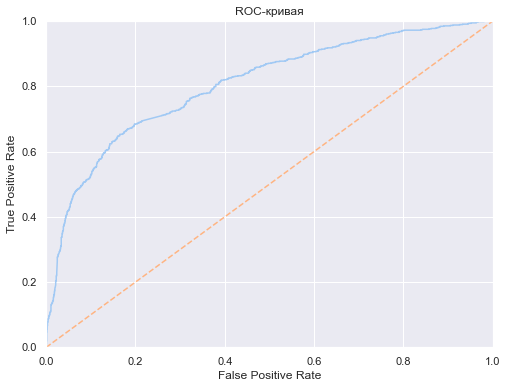

F1: 0.596
ROC_auc: 0.71
Precision: 0.719
Recall: 0.509


In [62]:
results(model_lgbm_class_bow, X_test_bow, y_test_class)

In [63]:
%%time
#LightGBM with TF-IDF
model_lgbm_class_tfidf = model_lgbm.fit(X_train_tfidf, y_train_class)

prediction_lgbm_class_tfidf = model_lgbm_class_tfidf.predict(X_test_tfidf)

f1_lgbm_tfidf_cv = model_lgbm_class_tfidf.best_score_

print('F1 best CV: ', f1_lgbm_tfidf_cv)
print('Best params: ', model_lgbm_class_tfidf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.583 total time=   1.9s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.611 total time=   1.8s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.617 total time=   2.0s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.587 total time=   2.0s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.597 total time=   1.8s
[CV 1/5] END ...max_depth=10, n_estimators=1000;, score=0.579 total time=   3.6s
[CV 2/5] END ...max_depth=10, n_estimators=1000;, score=0.609 total time=   3.6s
[CV 3/5] END ...max_depth=10, n_estimators=1000;, score=0.610 total time=   3.6s
[CV 4/5] END ...max_depth=10, n_estimators=1000;, score=0.590 total time=   3.7s
[CV 5/5] END ...max_depth=10, n_estimators=1000;, score=0.587 total time=   3.5s
[CV 1/5] END ....max_depth=13, n_estimators=500;, score=0.585 total time=   2.2s
[CV 2/5] END ....max_depth=13, n_estimators=500;,

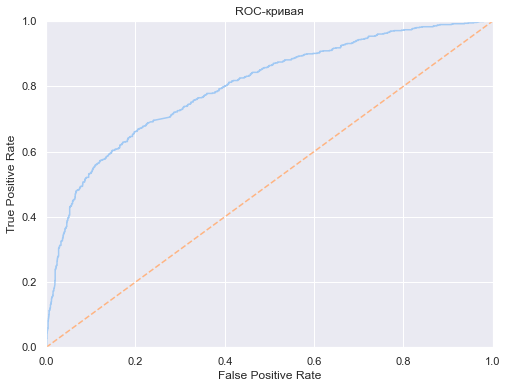

F1: 0.602
ROC_auc: 0.714
Precision: 0.713
Recall: 0.521


In [64]:
results(model_lgbm_class_tfidf, X_test_tfidf, y_test_class)

### CatBoost

In [80]:
#CatBoost model
params = {
    'max_depth' : [10],
    'n_estimators' : [1000]
}
model_catboost = CatBoostClassifier(random_state=RANDOM_STATE)
model_catboost = GridSearchCV(model_catboost, params, scoring='f1', verbose=4)

In [81]:
%%time
#CatBoost with BOW
model_catboost_class_bow = model_catboost.fit(X_train_bow, y_train_class)

prediction_catboost_class_bow = model_catboost_class_bow.predict(X_test_bow)

f1_catboost_bow_cv = model_catboost_class_bow.best_score_

print('F1 best CV: ', f1_catboost_bow_cv)
print('Best params: ', model_catboost_class_bow.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.021948
0:	learn: 0.6849823	total: 51.4ms	remaining: 51.4s
1:	learn: 0.6774001	total: 101ms	remaining: 50.3s
2:	learn: 0.6693001	total: 150ms	remaining: 49.8s
3:	learn: 0.6625614	total: 198ms	remaining: 49.3s
4:	learn: 0.6550217	total: 246ms	remaining: 49s
5:	learn: 0.6485061	total: 295ms	remaining: 48.8s
6:	learn: 0.6425732	total: 342ms	remaining: 48.6s
7:	learn: 0.6367135	total: 392ms	remaining: 48.6s
8:	learn: 0.6311544	total: 440ms	remaining: 48.4s
9:	learn: 0.6252810	total: 488ms	remaining: 48.3s
10:	learn: 0.6204635	total: 536ms	remaining: 48.2s
11:	learn: 0.6158207	total: 585ms	remaining: 48.2s
12:	learn: 0.6113629	total: 635ms	remaining: 48.2s
13:	learn: 0.6066292	total: 684ms	remaining: 48.2s
14:	learn: 0.6022269	total: 733ms	remaining: 48.1s
15:	learn: 0.5982317	total: 781ms	remaining: 48s
16:	learn: 0.5942719	total: 831ms	remaining: 48.1s
17:	learn: 0.5906532	total: 881ms	remaining: 48s
18:	lear

159:	learn: 0.4589640	total: 7.84s	remaining: 41.1s
160:	learn: 0.4587469	total: 7.89s	remaining: 41.1s
161:	learn: 0.4585701	total: 7.93s	remaining: 41s
162:	learn: 0.4583462	total: 7.98s	remaining: 41s
163:	learn: 0.4580410	total: 8.03s	remaining: 40.9s
164:	learn: 0.4577918	total: 8.09s	remaining: 40.9s
165:	learn: 0.4576760	total: 8.14s	remaining: 40.9s
166:	learn: 0.4575104	total: 8.19s	remaining: 40.8s
167:	learn: 0.4572067	total: 8.24s	remaining: 40.8s
168:	learn: 0.4570592	total: 8.29s	remaining: 40.8s
169:	learn: 0.4566161	total: 8.34s	remaining: 40.7s
170:	learn: 0.4562366	total: 8.4s	remaining: 40.7s
171:	learn: 0.4560328	total: 8.45s	remaining: 40.7s
172:	learn: 0.4557847	total: 8.51s	remaining: 40.7s
173:	learn: 0.4554582	total: 8.55s	remaining: 40.6s
174:	learn: 0.4550899	total: 8.61s	remaining: 40.6s
175:	learn: 0.4547662	total: 8.66s	remaining: 40.5s
176:	learn: 0.4545529	total: 8.71s	remaining: 40.5s
177:	learn: 0.4542006	total: 8.77s	remaining: 40.5s
178:	learn: 0.453

319:	learn: 0.4264259	total: 15.8s	remaining: 33.5s
320:	learn: 0.4261178	total: 15.8s	remaining: 33.4s
321:	learn: 0.4259445	total: 15.9s	remaining: 33.4s
322:	learn: 0.4258302	total: 15.9s	remaining: 33.3s
323:	learn: 0.4253895	total: 15.9s	remaining: 33.3s
324:	learn: 0.4252921	total: 16s	remaining: 33.2s
325:	learn: 0.4251154	total: 16s	remaining: 33.2s
326:	learn: 0.4250247	total: 16.1s	remaining: 33.1s
327:	learn: 0.4248230	total: 16.1s	remaining: 33.1s
328:	learn: 0.4246436	total: 16.2s	remaining: 33s
329:	learn: 0.4243946	total: 16.2s	remaining: 33s
330:	learn: 0.4243068	total: 16.3s	remaining: 32.9s
331:	learn: 0.4242298	total: 16.3s	remaining: 32.9s
332:	learn: 0.4238173	total: 16.4s	remaining: 32.8s
333:	learn: 0.4236767	total: 16.4s	remaining: 32.8s
334:	learn: 0.4236441	total: 16.5s	remaining: 32.7s
335:	learn: 0.4233961	total: 16.5s	remaining: 32.7s
336:	learn: 0.4230717	total: 16.6s	remaining: 32.6s
337:	learn: 0.4229793	total: 16.6s	remaining: 32.6s
338:	learn: 0.422858

479:	learn: 0.3879942	total: 23.6s	remaining: 25.5s
480:	learn: 0.3877176	total: 23.6s	remaining: 25.5s
481:	learn: 0.3874423	total: 23.7s	remaining: 25.4s
482:	learn: 0.3870903	total: 23.7s	remaining: 25.4s
483:	learn: 0.3867581	total: 23.7s	remaining: 25.3s
484:	learn: 0.3865418	total: 23.8s	remaining: 25.3s
485:	learn: 0.3862100	total: 23.8s	remaining: 25.2s
486:	learn: 0.3859521	total: 23.9s	remaining: 25.2s
487:	learn: 0.3858468	total: 23.9s	remaining: 25.1s
488:	learn: 0.3856287	total: 24s	remaining: 25.1s
489:	learn: 0.3853567	total: 24.1s	remaining: 25s
490:	learn: 0.3849428	total: 24.1s	remaining: 25s
491:	learn: 0.3846844	total: 24.2s	remaining: 24.9s
492:	learn: 0.3842926	total: 24.2s	remaining: 24.9s
493:	learn: 0.3838172	total: 24.3s	remaining: 24.8s
494:	learn: 0.3833016	total: 24.3s	remaining: 24.8s
495:	learn: 0.3830500	total: 24.4s	remaining: 24.8s
496:	learn: 0.3825770	total: 24.4s	remaining: 24.7s
497:	learn: 0.3822969	total: 24.5s	remaining: 24.7s
498:	learn: 0.3820

641:	learn: 0.3464546	total: 31.7s	remaining: 17.7s
642:	learn: 0.3463011	total: 31.7s	remaining: 17.6s
643:	learn: 0.3460522	total: 31.8s	remaining: 17.6s
644:	learn: 0.3458563	total: 31.8s	remaining: 17.5s
645:	learn: 0.3456895	total: 31.9s	remaining: 17.5s
646:	learn: 0.3453584	total: 31.9s	remaining: 17.4s
647:	learn: 0.3451537	total: 32s	remaining: 17.4s
648:	learn: 0.3448399	total: 32s	remaining: 17.3s
649:	learn: 0.3444722	total: 32.1s	remaining: 17.3s
650:	learn: 0.3441081	total: 32.1s	remaining: 17.2s
651:	learn: 0.3436349	total: 32.2s	remaining: 17.2s
652:	learn: 0.3434644	total: 32.2s	remaining: 17.1s
653:	learn: 0.3433001	total: 32.3s	remaining: 17.1s
654:	learn: 0.3430371	total: 32.3s	remaining: 17s
655:	learn: 0.3428261	total: 32.4s	remaining: 17s
656:	learn: 0.3427757	total: 32.4s	remaining: 16.9s
657:	learn: 0.3426557	total: 32.5s	remaining: 16.9s
658:	learn: 0.3424386	total: 32.5s	remaining: 16.8s
659:	learn: 0.3422558	total: 32.6s	remaining: 16.8s
660:	learn: 0.341703

802:	learn: 0.3164041	total: 40.1s	remaining: 9.84s
803:	learn: 0.3163738	total: 40.2s	remaining: 9.79s
804:	learn: 0.3162266	total: 40.2s	remaining: 9.74s
805:	learn: 0.3160427	total: 40.3s	remaining: 9.69s
806:	learn: 0.3158722	total: 40.3s	remaining: 9.64s
807:	learn: 0.3157592	total: 40.4s	remaining: 9.59s
808:	learn: 0.3155100	total: 40.4s	remaining: 9.54s
809:	learn: 0.3153973	total: 40.5s	remaining: 9.49s
810:	learn: 0.3151813	total: 40.5s	remaining: 9.45s
811:	learn: 0.3149318	total: 40.6s	remaining: 9.4s
812:	learn: 0.3147814	total: 40.6s	remaining: 9.35s
813:	learn: 0.3146851	total: 40.7s	remaining: 9.3s
814:	learn: 0.3145339	total: 40.8s	remaining: 9.25s
815:	learn: 0.3141965	total: 40.8s	remaining: 9.2s
816:	learn: 0.3139978	total: 40.9s	remaining: 9.15s
817:	learn: 0.3137205	total: 40.9s	remaining: 9.1s
818:	learn: 0.3136863	total: 41s	remaining: 9.05s
819:	learn: 0.3134865	total: 41s	remaining: 9.01s
820:	learn: 0.3132367	total: 41.1s	remaining: 8.96s
821:	learn: 0.312942

962:	learn: 0.2934386	total: 48.6s	remaining: 1.87s
963:	learn: 0.2931652	total: 48.7s	remaining: 1.82s
964:	learn: 0.2929277	total: 48.7s	remaining: 1.77s
965:	learn: 0.2928160	total: 48.8s	remaining: 1.72s
966:	learn: 0.2926292	total: 48.8s	remaining: 1.67s
967:	learn: 0.2926035	total: 48.9s	remaining: 1.62s
968:	learn: 0.2923955	total: 48.9s	remaining: 1.56s
969:	learn: 0.2923262	total: 49s	remaining: 1.51s
970:	learn: 0.2921983	total: 49s	remaining: 1.46s
971:	learn: 0.2921735	total: 49.1s	remaining: 1.41s
972:	learn: 0.2920384	total: 49.1s	remaining: 1.36s
973:	learn: 0.2918576	total: 49.2s	remaining: 1.31s
974:	learn: 0.2917843	total: 49.3s	remaining: 1.26s
975:	learn: 0.2917589	total: 49.3s	remaining: 1.21s
976:	learn: 0.2915946	total: 49.4s	remaining: 1.16s
977:	learn: 0.2915373	total: 49.4s	remaining: 1.11s
978:	learn: 0.2914624	total: 49.5s	remaining: 1.06s
979:	learn: 0.2912663	total: 49.5s	remaining: 1.01s
980:	learn: 0.2910337	total: 49.6s	remaining: 960ms
981:	learn: 0.29

122:	learn: 0.4734584	total: 7.49s	remaining: 53.4s
123:	learn: 0.4732624	total: 7.56s	remaining: 53.4s
124:	learn: 0.4725945	total: 7.62s	remaining: 53.3s
125:	learn: 0.4723377	total: 7.68s	remaining: 53.3s
126:	learn: 0.4719956	total: 7.75s	remaining: 53.2s
127:	learn: 0.4716712	total: 7.81s	remaining: 53.2s
128:	learn: 0.4714625	total: 7.87s	remaining: 53.1s
129:	learn: 0.4712163	total: 7.93s	remaining: 53.1s
130:	learn: 0.4706523	total: 7.99s	remaining: 53s
131:	learn: 0.4704090	total: 8.05s	remaining: 53s
132:	learn: 0.4701699	total: 8.11s	remaining: 52.9s
133:	learn: 0.4698373	total: 8.18s	remaining: 52.8s
134:	learn: 0.4693416	total: 8.24s	remaining: 52.8s
135:	learn: 0.4689649	total: 8.3s	remaining: 52.7s
136:	learn: 0.4686098	total: 8.36s	remaining: 52.6s
137:	learn: 0.4683177	total: 8.42s	remaining: 52.6s
138:	learn: 0.4680861	total: 8.48s	remaining: 52.5s
139:	learn: 0.4678475	total: 8.54s	remaining: 52.5s
140:	learn: 0.4676688	total: 8.6s	remaining: 52.4s
141:	learn: 0.4674

282:	learn: 0.4363772	total: 17.2s	remaining: 43.7s
283:	learn: 0.4361621	total: 17.3s	remaining: 43.6s
284:	learn: 0.4360488	total: 17.4s	remaining: 43.5s
285:	learn: 0.4359231	total: 17.4s	remaining: 43.5s
286:	learn: 0.4357171	total: 17.5s	remaining: 43.4s
287:	learn: 0.4355594	total: 17.5s	remaining: 43.4s
288:	learn: 0.4354362	total: 17.6s	remaining: 43.3s
289:	learn: 0.4353029	total: 17.7s	remaining: 43.2s
290:	learn: 0.4351852	total: 17.7s	remaining: 43.2s
291:	learn: 0.4349528	total: 17.8s	remaining: 43.1s
292:	learn: 0.4348216	total: 17.8s	remaining: 43s
293:	learn: 0.4346330	total: 17.9s	remaining: 43s
294:	learn: 0.4344873	total: 18s	remaining: 42.9s
295:	learn: 0.4342669	total: 18s	remaining: 42.9s
296:	learn: 0.4341172	total: 18.1s	remaining: 42.8s
297:	learn: 0.4339848	total: 18.1s	remaining: 42.7s
298:	learn: 0.4338118	total: 18.2s	remaining: 42.7s
299:	learn: 0.4336544	total: 18.3s	remaining: 42.6s
300:	learn: 0.4335200	total: 18.3s	remaining: 42.5s
301:	learn: 0.433310

442:	learn: 0.4018754	total: 26.8s	remaining: 33.8s
443:	learn: 0.4015886	total: 26.9s	remaining: 33.7s
444:	learn: 0.4014181	total: 27s	remaining: 33.6s
445:	learn: 0.4012121	total: 27s	remaining: 33.6s
446:	learn: 0.4008039	total: 27.1s	remaining: 33.5s
447:	learn: 0.4007039	total: 27.1s	remaining: 33.4s
448:	learn: 0.4005716	total: 27.2s	remaining: 33.4s
449:	learn: 0.3998763	total: 27.3s	remaining: 33.3s
450:	learn: 0.3997046	total: 27.3s	remaining: 33.3s
451:	learn: 0.3992511	total: 27.4s	remaining: 33.2s
452:	learn: 0.3988281	total: 27.4s	remaining: 33.1s
453:	learn: 0.3985791	total: 27.5s	remaining: 33.1s
454:	learn: 0.3983562	total: 27.6s	remaining: 33s
455:	learn: 0.3981763	total: 27.6s	remaining: 32.9s
456:	learn: 0.3980070	total: 27.7s	remaining: 32.9s
457:	learn: 0.3975863	total: 27.7s	remaining: 32.8s
458:	learn: 0.3972109	total: 27.8s	remaining: 32.8s
459:	learn: 0.3970565	total: 27.8s	remaining: 32.7s
460:	learn: 0.3967746	total: 27.9s	remaining: 32.6s
461:	learn: 0.3964

602:	learn: 0.3627636	total: 36.4s	remaining: 24s
603:	learn: 0.3622740	total: 36.5s	remaining: 23.9s
604:	learn: 0.3619076	total: 36.5s	remaining: 23.8s
605:	learn: 0.3617729	total: 36.6s	remaining: 23.8s
606:	learn: 0.3617170	total: 36.6s	remaining: 23.7s
607:	learn: 0.3615456	total: 36.7s	remaining: 23.7s
608:	learn: 0.3614725	total: 36.8s	remaining: 23.6s
609:	learn: 0.3613999	total: 36.8s	remaining: 23.5s
610:	learn: 0.3607985	total: 36.9s	remaining: 23.5s
611:	learn: 0.3605705	total: 36.9s	remaining: 23.4s
612:	learn: 0.3600900	total: 37s	remaining: 23.4s
613:	learn: 0.3600369	total: 37.1s	remaining: 23.3s
614:	learn: 0.3599280	total: 37.1s	remaining: 23.2s
615:	learn: 0.3597172	total: 37.2s	remaining: 23.2s
616:	learn: 0.3595744	total: 37.3s	remaining: 23.1s
617:	learn: 0.3592851	total: 37.3s	remaining: 23.1s
618:	learn: 0.3591829	total: 37.4s	remaining: 23s
619:	learn: 0.3587867	total: 37.4s	remaining: 22.9s
620:	learn: 0.3585256	total: 37.5s	remaining: 22.9s
621:	learn: 0.3584

762:	learn: 0.3295442	total: 46.1s	remaining: 14.3s
763:	learn: 0.3295113	total: 46.2s	remaining: 14.3s
764:	learn: 0.3292597	total: 46.2s	remaining: 14.2s
765:	learn: 0.3291407	total: 46.3s	remaining: 14.1s
766:	learn: 0.3290236	total: 46.4s	remaining: 14.1s
767:	learn: 0.3288090	total: 46.4s	remaining: 14s
768:	learn: 0.3286833	total: 46.5s	remaining: 14s
769:	learn: 0.3286361	total: 46.5s	remaining: 13.9s
770:	learn: 0.3286004	total: 46.6s	remaining: 13.8s
771:	learn: 0.3283269	total: 46.7s	remaining: 13.8s
772:	learn: 0.3280910	total: 46.7s	remaining: 13.7s
773:	learn: 0.3278363	total: 46.8s	remaining: 13.7s
774:	learn: 0.3277851	total: 46.8s	remaining: 13.6s
775:	learn: 0.3275304	total: 46.9s	remaining: 13.5s
776:	learn: 0.3274907	total: 47s	remaining: 13.5s
777:	learn: 0.3272141	total: 47s	remaining: 13.4s
778:	learn: 0.3269389	total: 47.1s	remaining: 13.4s
779:	learn: 0.3268549	total: 47.1s	remaining: 13.3s
780:	learn: 0.3268220	total: 47.2s	remaining: 13.2s
781:	learn: 0.326508

922:	learn: 0.3042128	total: 56s	remaining: 4.67s
923:	learn: 0.3040938	total: 56.1s	remaining: 4.61s
924:	learn: 0.3040660	total: 56.1s	remaining: 4.55s
925:	learn: 0.3040386	total: 56.2s	remaining: 4.49s
926:	learn: 0.3038783	total: 56.2s	remaining: 4.43s
927:	learn: 0.3037322	total: 56.3s	remaining: 4.37s
928:	learn: 0.3035948	total: 56.4s	remaining: 4.31s
929:	learn: 0.3034353	total: 56.4s	remaining: 4.25s
930:	learn: 0.3033659	total: 56.5s	remaining: 4.19s
931:	learn: 0.3031752	total: 56.5s	remaining: 4.13s
932:	learn: 0.3029937	total: 56.6s	remaining: 4.06s
933:	learn: 0.3029482	total: 56.7s	remaining: 4s
934:	learn: 0.3028240	total: 56.7s	remaining: 3.94s
935:	learn: 0.3027969	total: 56.8s	remaining: 3.88s
936:	learn: 0.3027383	total: 56.9s	remaining: 3.82s
937:	learn: 0.3027147	total: 56.9s	remaining: 3.76s
938:	learn: 0.3025834	total: 57s	remaining: 3.7s
939:	learn: 0.3025209	total: 57s	remaining: 3.64s
940:	learn: 0.3022911	total: 57.1s	remaining: 3.58s
941:	learn: 0.3020396	

82:	learn: 0.4964904	total: 5.71s	remaining: 1m 3s
83:	learn: 0.4958922	total: 5.78s	remaining: 1m 3s
84:	learn: 0.4950087	total: 5.85s	remaining: 1m 2s
85:	learn: 0.4944551	total: 5.92s	remaining: 1m 2s
86:	learn: 0.4937898	total: 5.99s	remaining: 1m 2s
87:	learn: 0.4934353	total: 6.06s	remaining: 1m 2s
88:	learn: 0.4926518	total: 6.12s	remaining: 1m 2s
89:	learn: 0.4922929	total: 6.19s	remaining: 1m 2s
90:	learn: 0.4914895	total: 6.26s	remaining: 1m 2s
91:	learn: 0.4909358	total: 6.33s	remaining: 1m 2s
92:	learn: 0.4903707	total: 6.39s	remaining: 1m 2s
93:	learn: 0.4896069	total: 6.46s	remaining: 1m 2s
94:	learn: 0.4890961	total: 6.53s	remaining: 1m 2s
95:	learn: 0.4886368	total: 6.6s	remaining: 1m 2s
96:	learn: 0.4880944	total: 6.67s	remaining: 1m 2s
97:	learn: 0.4876110	total: 6.74s	remaining: 1m 1s
98:	learn: 0.4870072	total: 6.8s	remaining: 1m 1s
99:	learn: 0.4865072	total: 6.87s	remaining: 1m 1s
100:	learn: 0.4859037	total: 6.94s	remaining: 1m 1s
101:	learn: 0.4855890	total: 7.0

245:	learn: 0.4437305	total: 16.8s	remaining: 51.6s
246:	learn: 0.4434084	total: 16.9s	remaining: 51.5s
247:	learn: 0.4432833	total: 17s	remaining: 51.4s
248:	learn: 0.4431577	total: 17s	remaining: 51.4s
249:	learn: 0.4430955	total: 17.1s	remaining: 51.3s
250:	learn: 0.4430233	total: 17.2s	remaining: 51.2s
251:	learn: 0.4427960	total: 17.2s	remaining: 51.2s
252:	learn: 0.4426613	total: 17.3s	remaining: 51.1s
253:	learn: 0.4425035	total: 17.4s	remaining: 51s
254:	learn: 0.4423423	total: 17.4s	remaining: 50.9s
255:	learn: 0.4421232	total: 17.5s	remaining: 50.9s
256:	learn: 0.4418618	total: 17.6s	remaining: 50.8s
257:	learn: 0.4417916	total: 17.6s	remaining: 50.7s
258:	learn: 0.4413925	total: 17.7s	remaining: 50.7s
259:	learn: 0.4412882	total: 17.8s	remaining: 50.6s
260:	learn: 0.4412048	total: 17.8s	remaining: 50.5s
261:	learn: 0.4410984	total: 17.9s	remaining: 50.4s
262:	learn: 0.4409766	total: 18s	remaining: 50.4s
263:	learn: 0.4408188	total: 18s	remaining: 50.3s
264:	learn: 0.4405556	

405:	learn: 0.4144178	total: 27.6s	remaining: 40.4s
406:	learn: 0.4142768	total: 27.7s	remaining: 40.4s
407:	learn: 0.4139104	total: 27.8s	remaining: 40.3s
408:	learn: 0.4136563	total: 27.8s	remaining: 40.2s
409:	learn: 0.4134614	total: 27.9s	remaining: 40.1s
410:	learn: 0.4132692	total: 28s	remaining: 40.1s
411:	learn: 0.4127277	total: 28s	remaining: 40s
412:	learn: 0.4123021	total: 28.1s	remaining: 39.9s
413:	learn: 0.4119606	total: 28.2s	remaining: 39.9s
414:	learn: 0.4116385	total: 28.2s	remaining: 39.8s
415:	learn: 0.4113226	total: 28.3s	remaining: 39.7s
416:	learn: 0.4111402	total: 28.4s	remaining: 39.7s
417:	learn: 0.4105704	total: 28.4s	remaining: 39.6s
418:	learn: 0.4101624	total: 28.5s	remaining: 39.5s
419:	learn: 0.4100211	total: 28.6s	remaining: 39.5s
420:	learn: 0.4096671	total: 28.6s	remaining: 39.4s
421:	learn: 0.4092618	total: 28.7s	remaining: 39.3s
422:	learn: 0.4090990	total: 28.8s	remaining: 39.2s
423:	learn: 0.4089183	total: 28.8s	remaining: 39.2s
424:	learn: 0.4088

564:	learn: 0.3698072	total: 38.2s	remaining: 29.4s
565:	learn: 0.3693807	total: 38.3s	remaining: 29.3s
566:	learn: 0.3691430	total: 38.3s	remaining: 29.3s
567:	learn: 0.3689961	total: 38.4s	remaining: 29.2s
568:	learn: 0.3689106	total: 38.5s	remaining: 29.1s
569:	learn: 0.3686405	total: 38.5s	remaining: 29.1s
570:	learn: 0.3684700	total: 38.6s	remaining: 29s
571:	learn: 0.3677544	total: 38.7s	remaining: 28.9s
572:	learn: 0.3676764	total: 38.7s	remaining: 28.9s
573:	learn: 0.3674369	total: 38.8s	remaining: 28.8s
574:	learn: 0.3671833	total: 38.9s	remaining: 28.7s
575:	learn: 0.3668335	total: 38.9s	remaining: 28.7s
576:	learn: 0.3664222	total: 39s	remaining: 28.6s
577:	learn: 0.3663626	total: 39.1s	remaining: 28.5s
578:	learn: 0.3662223	total: 39.1s	remaining: 28.5s
579:	learn: 0.3659868	total: 39.2s	remaining: 28.4s
580:	learn: 0.3658894	total: 39.3s	remaining: 28.3s
581:	learn: 0.3655603	total: 39.3s	remaining: 28.2s
582:	learn: 0.3654986	total: 39.4s	remaining: 28.2s
583:	learn: 0.36

725:	learn: 0.3332697	total: 48.9s	remaining: 18.4s
726:	learn: 0.3330952	total: 48.9s	remaining: 18.4s
727:	learn: 0.3325267	total: 49s	remaining: 18.3s
728:	learn: 0.3323440	total: 49.1s	remaining: 18.2s
729:	learn: 0.3322514	total: 49.1s	remaining: 18.2s
730:	learn: 0.3319872	total: 49.2s	remaining: 18.1s
731:	learn: 0.3317321	total: 49.3s	remaining: 18s
732:	learn: 0.3316897	total: 49.3s	remaining: 18s
733:	learn: 0.3316493	total: 49.4s	remaining: 17.9s
734:	learn: 0.3315230	total: 49.5s	remaining: 17.8s
735:	learn: 0.3312060	total: 49.5s	remaining: 17.8s
736:	learn: 0.3310415	total: 49.6s	remaining: 17.7s
737:	learn: 0.3308561	total: 49.7s	remaining: 17.6s
738:	learn: 0.3305518	total: 49.7s	remaining: 17.6s
739:	learn: 0.3305159	total: 49.8s	remaining: 17.5s
740:	learn: 0.3304777	total: 49.9s	remaining: 17.4s
741:	learn: 0.3300107	total: 49.9s	remaining: 17.4s
742:	learn: 0.3297310	total: 50s	remaining: 17.3s
743:	learn: 0.3296939	total: 50.1s	remaining: 17.2s
744:	learn: 0.329476

886:	learn: 0.3067297	total: 59.9s	remaining: 7.63s
887:	learn: 0.3066426	total: 60s	remaining: 7.56s
888:	learn: 0.3066152	total: 1m	remaining: 7.5s
889:	learn: 0.3063790	total: 1m	remaining: 7.43s
890:	learn: 0.3062574	total: 1m	remaining: 7.36s
891:	learn: 0.3061236	total: 1m	remaining: 7.29s
892:	learn: 0.3060718	total: 1m	remaining: 7.23s
893:	learn: 0.3060053	total: 1m	remaining: 7.16s
894:	learn: 0.3057863	total: 1m	remaining: 7.09s
895:	learn: 0.3057521	total: 1m	remaining: 7.02s
896:	learn: 0.3057259	total: 1m	remaining: 6.96s
897:	learn: 0.3057002	total: 1m	remaining: 6.89s
898:	learn: 0.3055080	total: 1m	remaining: 6.82s
899:	learn: 0.3054736	total: 1m	remaining: 6.75s
900:	learn: 0.3053521	total: 1m	remaining: 6.69s
901:	learn: 0.3052585	total: 1m	remaining: 6.62s
902:	learn: 0.3052314	total: 1m 1s	remaining: 6.55s
903:	learn: 0.3051806	total: 1m 1s	remaining: 6.49s
904:	learn: 0.3050175	total: 1m 1s	remaining: 6.42s
905:	learn: 0.3049240	total: 1m 1s	remaining: 6.35s
906:	

45:	learn: 0.5286938	total: 3.11s	remaining: 1m 4s
46:	learn: 0.5273698	total: 3.18s	remaining: 1m 4s
47:	learn: 0.5261652	total: 3.24s	remaining: 1m 4s
48:	learn: 0.5252778	total: 3.31s	remaining: 1m 4s
49:	learn: 0.5238281	total: 3.38s	remaining: 1m 4s
50:	learn: 0.5222363	total: 3.45s	remaining: 1m 4s
51:	learn: 0.5211074	total: 3.51s	remaining: 1m 4s
52:	learn: 0.5186197	total: 3.58s	remaining: 1m 4s
53:	learn: 0.5173444	total: 3.65s	remaining: 1m 3s
54:	learn: 0.5163426	total: 3.72s	remaining: 1m 3s
55:	learn: 0.5155817	total: 3.78s	remaining: 1m 3s
56:	learn: 0.5147135	total: 3.85s	remaining: 1m 3s
57:	learn: 0.5137044	total: 3.92s	remaining: 1m 3s
58:	learn: 0.5123374	total: 3.99s	remaining: 1m 3s
59:	learn: 0.5110309	total: 4.07s	remaining: 1m 3s
60:	learn: 0.5104536	total: 4.13s	remaining: 1m 3s
61:	learn: 0.5095531	total: 4.2s	remaining: 1m 3s
62:	learn: 0.5086074	total: 4.27s	remaining: 1m 3s
63:	learn: 0.5075085	total: 4.34s	remaining: 1m 3s
64:	learn: 0.5066343	total: 4.42

206:	learn: 0.4506684	total: 14.1s	remaining: 53.9s
207:	learn: 0.4503995	total: 14.1s	remaining: 53.8s
208:	learn: 0.4502122	total: 14.2s	remaining: 53.8s
209:	learn: 0.4499142	total: 14.3s	remaining: 53.7s
210:	learn: 0.4497779	total: 14.3s	remaining: 53.6s
211:	learn: 0.4495280	total: 14.4s	remaining: 53.5s
212:	learn: 0.4492576	total: 14.5s	remaining: 53.5s
213:	learn: 0.4490515	total: 14.5s	remaining: 53.4s
214:	learn: 0.4488421	total: 14.6s	remaining: 53.3s
215:	learn: 0.4486573	total: 14.7s	remaining: 53.3s
216:	learn: 0.4483684	total: 14.7s	remaining: 53.2s
217:	learn: 0.4481179	total: 14.8s	remaining: 53.1s
218:	learn: 0.4479433	total: 14.9s	remaining: 53.1s
219:	learn: 0.4478345	total: 14.9s	remaining: 53s
220:	learn: 0.4475410	total: 15s	remaining: 52.9s
221:	learn: 0.4474171	total: 15.1s	remaining: 52.8s
222:	learn: 0.4471265	total: 15.1s	remaining: 52.8s
223:	learn: 0.4468392	total: 15.2s	remaining: 52.7s
224:	learn: 0.4465401	total: 15.3s	remaining: 52.6s
225:	learn: 0.44

366:	learn: 0.4190066	total: 24.9s	remaining: 42.9s
367:	learn: 0.4188141	total: 24.9s	remaining: 42.8s
368:	learn: 0.4187638	total: 25s	remaining: 42.8s
369:	learn: 0.4185457	total: 25.1s	remaining: 42.7s
370:	learn: 0.4184282	total: 25.1s	remaining: 42.6s
371:	learn: 0.4183113	total: 25.2s	remaining: 42.6s
372:	learn: 0.4178483	total: 25.3s	remaining: 42.5s
373:	learn: 0.4178058	total: 25.3s	remaining: 42.4s
374:	learn: 0.4175887	total: 25.4s	remaining: 42.4s
375:	learn: 0.4174103	total: 25.5s	remaining: 42.3s
376:	learn: 0.4172950	total: 25.6s	remaining: 42.2s
377:	learn: 0.4171186	total: 25.6s	remaining: 42.2s
378:	learn: 0.4169479	total: 25.7s	remaining: 42.1s
379:	learn: 0.4164045	total: 25.8s	remaining: 42s
380:	learn: 0.4162157	total: 25.8s	remaining: 41.9s
381:	learn: 0.4160818	total: 25.9s	remaining: 41.9s
382:	learn: 0.4159416	total: 26s	remaining: 41.8s
383:	learn: 0.4157972	total: 26s	remaining: 41.7s
384:	learn: 0.4156154	total: 26.1s	remaining: 41.7s
385:	learn: 0.415366

527:	learn: 0.3744940	total: 35.6s	remaining: 31.9s
528:	learn: 0.3741008	total: 35.7s	remaining: 31.8s
529:	learn: 0.3736255	total: 35.8s	remaining: 31.7s
530:	learn: 0.3734487	total: 35.8s	remaining: 31.7s
531:	learn: 0.3730894	total: 35.9s	remaining: 31.6s
532:	learn: 0.3727004	total: 36s	remaining: 31.5s
533:	learn: 0.3723783	total: 36s	remaining: 31.5s
534:	learn: 0.3723054	total: 36.1s	remaining: 31.4s
535:	learn: 0.3719795	total: 36.2s	remaining: 31.3s
536:	learn: 0.3717626	total: 36.3s	remaining: 31.3s
537:	learn: 0.3715836	total: 36.3s	remaining: 31.2s
538:	learn: 0.3713280	total: 36.4s	remaining: 31.1s
539:	learn: 0.3709733	total: 36.5s	remaining: 31.1s
540:	learn: 0.3706433	total: 36.5s	remaining: 31s
541:	learn: 0.3703426	total: 36.6s	remaining: 30.9s
542:	learn: 0.3701534	total: 36.7s	remaining: 30.9s
543:	learn: 0.3696359	total: 36.7s	remaining: 30.8s
544:	learn: 0.3694535	total: 36.8s	remaining: 30.7s
545:	learn: 0.3691276	total: 36.9s	remaining: 30.7s
546:	learn: 0.3686

687:	learn: 0.3379138	total: 46.4s	remaining: 21.1s
688:	learn: 0.3378622	total: 46.5s	remaining: 21s
689:	learn: 0.3376837	total: 46.6s	remaining: 20.9s
690:	learn: 0.3376102	total: 46.6s	remaining: 20.8s
691:	learn: 0.3375476	total: 46.7s	remaining: 20.8s
692:	learn: 0.3372481	total: 46.8s	remaining: 20.7s
693:	learn: 0.3369967	total: 46.8s	remaining: 20.6s
694:	learn: 0.3368057	total: 46.9s	remaining: 20.6s
695:	learn: 0.3366834	total: 47s	remaining: 20.5s
696:	learn: 0.3365487	total: 47s	remaining: 20.4s
697:	learn: 0.3362572	total: 47.1s	remaining: 20.4s
698:	learn: 0.3361086	total: 47.2s	remaining: 20.3s
699:	learn: 0.3360128	total: 47.2s	remaining: 20.2s
700:	learn: 0.3356486	total: 47.3s	remaining: 20.2s
701:	learn: 0.3354586	total: 47.4s	remaining: 20.1s
702:	learn: 0.3353280	total: 47.4s	remaining: 20s
703:	learn: 0.3350777	total: 47.5s	remaining: 20s
704:	learn: 0.3347783	total: 47.6s	remaining: 19.9s
705:	learn: 0.3346184	total: 47.6s	remaining: 19.8s
706:	learn: 0.3345777	

846:	learn: 0.3104479	total: 57.5s	remaining: 10.4s
847:	learn: 0.3103604	total: 57.6s	remaining: 10.3s
848:	learn: 0.3102871	total: 57.6s	remaining: 10.3s
849:	learn: 0.3101126	total: 57.7s	remaining: 10.2s
850:	learn: 0.3098723	total: 57.8s	remaining: 10.1s
851:	learn: 0.3095694	total: 57.9s	remaining: 10s
852:	learn: 0.3095329	total: 57.9s	remaining: 9.98s
853:	learn: 0.3093787	total: 58s	remaining: 9.91s
854:	learn: 0.3092940	total: 58.1s	remaining: 9.85s
855:	learn: 0.3090731	total: 58.1s	remaining: 9.78s
856:	learn: 0.3089024	total: 58.2s	remaining: 9.71s
857:	learn: 0.3088703	total: 58.3s	remaining: 9.64s
858:	learn: 0.3087730	total: 58.3s	remaining: 9.58s
859:	learn: 0.3087337	total: 58.4s	remaining: 9.51s
860:	learn: 0.3085730	total: 58.5s	remaining: 9.44s
861:	learn: 0.3084799	total: 58.6s	remaining: 9.37s
862:	learn: 0.3082319	total: 58.6s	remaining: 9.31s
863:	learn: 0.3080230	total: 58.7s	remaining: 9.24s
864:	learn: 0.3079308	total: 58.8s	remaining: 9.17s
865:	learn: 0.30

5:	learn: 0.6501720	total: 390ms	remaining: 1m 4s
6:	learn: 0.6442592	total: 461ms	remaining: 1m 5s
7:	learn: 0.6381474	total: 533ms	remaining: 1m 6s
8:	learn: 0.6320990	total: 605ms	remaining: 1m 6s
9:	learn: 0.6268122	total: 677ms	remaining: 1m 7s
10:	learn: 0.6220860	total: 748ms	remaining: 1m 7s
11:	learn: 0.6171045	total: 822ms	remaining: 1m 7s
12:	learn: 0.6122393	total: 894ms	remaining: 1m 7s
13:	learn: 0.6081065	total: 966ms	remaining: 1m 8s
14:	learn: 0.6041807	total: 1.04s	remaining: 1m 8s
15:	learn: 0.5997860	total: 1.11s	remaining: 1m 8s
16:	learn: 0.5954343	total: 1.18s	remaining: 1m 8s
17:	learn: 0.5916685	total: 1.25s	remaining: 1m 8s
18:	learn: 0.5884092	total: 1.32s	remaining: 1m 8s
19:	learn: 0.5851065	total: 1.39s	remaining: 1m 8s
20:	learn: 0.5819767	total: 1.47s	remaining: 1m 8s
21:	learn: 0.5785640	total: 1.54s	remaining: 1m 8s
22:	learn: 0.5752486	total: 1.61s	remaining: 1m 8s
23:	learn: 0.5725523	total: 1.68s	remaining: 1m 8s
24:	learn: 0.5696669	total: 1.75s	re

166:	learn: 0.4606836	total: 11.8s	remaining: 59s
167:	learn: 0.4602786	total: 11.9s	remaining: 58.9s
168:	learn: 0.4601028	total: 12s	remaining: 58.8s
169:	learn: 0.4598283	total: 12s	remaining: 58.7s
170:	learn: 0.4595408	total: 12.1s	remaining: 58.7s
171:	learn: 0.4593860	total: 12.2s	remaining: 58.6s
172:	learn: 0.4592368	total: 12.2s	remaining: 58.5s
173:	learn: 0.4588769	total: 12.3s	remaining: 58.5s
174:	learn: 0.4587046	total: 12.4s	remaining: 58.4s
175:	learn: 0.4583968	total: 12.5s	remaining: 58.4s
176:	learn: 0.4582658	total: 12.5s	remaining: 58.3s
177:	learn: 0.4580174	total: 12.6s	remaining: 58.2s
178:	learn: 0.4578226	total: 12.7s	remaining: 58.2s
179:	learn: 0.4575664	total: 12.8s	remaining: 58.1s
180:	learn: 0.4573223	total: 12.8s	remaining: 58s
181:	learn: 0.4569263	total: 12.9s	remaining: 58s
182:	learn: 0.4567342	total: 13s	remaining: 57.9s
183:	learn: 0.4565934	total: 13s	remaining: 57.8s
184:	learn: 0.4564184	total: 13.1s	remaining: 57.7s
185:	learn: 0.4559382	tota

327:	learn: 0.4282136	total: 23.2s	remaining: 47.5s
328:	learn: 0.4280814	total: 23.3s	remaining: 47.5s
329:	learn: 0.4279359	total: 23.3s	remaining: 47.4s
330:	learn: 0.4276636	total: 23.4s	remaining: 47.3s
331:	learn: 0.4274015	total: 23.5s	remaining: 47.3s
332:	learn: 0.4271698	total: 23.6s	remaining: 47.2s
333:	learn: 0.4270439	total: 23.6s	remaining: 47.1s
334:	learn: 0.4269030	total: 23.7s	remaining: 47s
335:	learn: 0.4266207	total: 23.8s	remaining: 47s
336:	learn: 0.4264215	total: 23.8s	remaining: 46.9s
337:	learn: 0.4262994	total: 23.9s	remaining: 46.8s
338:	learn: 0.4261143	total: 24s	remaining: 46.8s
339:	learn: 0.4259882	total: 24.1s	remaining: 46.7s
340:	learn: 0.4258709	total: 24.1s	remaining: 46.6s
341:	learn: 0.4257674	total: 24.2s	remaining: 46.5s
342:	learn: 0.4254332	total: 24.3s	remaining: 46.5s
343:	learn: 0.4252447	total: 24.3s	remaining: 46.4s
344:	learn: 0.4250530	total: 24.4s	remaining: 46.3s
345:	learn: 0.4248966	total: 24.5s	remaining: 46.3s
346:	learn: 0.4247

488:	learn: 0.3860347	total: 34.7s	remaining: 36.3s
489:	learn: 0.3857739	total: 34.8s	remaining: 36.2s
490:	learn: 0.3856061	total: 34.8s	remaining: 36.1s
491:	learn: 0.3851667	total: 34.9s	remaining: 36s
492:	learn: 0.3849759	total: 35s	remaining: 36s
493:	learn: 0.3847808	total: 35.1s	remaining: 35.9s
494:	learn: 0.3844761	total: 35.1s	remaining: 35.8s
495:	learn: 0.3842616	total: 35.2s	remaining: 35.8s
496:	learn: 0.3841548	total: 35.3s	remaining: 35.7s
497:	learn: 0.3840694	total: 35.3s	remaining: 35.6s
498:	learn: 0.3839594	total: 35.4s	remaining: 35.6s
499:	learn: 0.3838485	total: 35.5s	remaining: 35.5s
500:	learn: 0.3837587	total: 35.6s	remaining: 35.4s
501:	learn: 0.3832968	total: 35.6s	remaining: 35.3s
502:	learn: 0.3827790	total: 35.7s	remaining: 35.3s
503:	learn: 0.3823177	total: 35.8s	remaining: 35.2s
504:	learn: 0.3821131	total: 35.8s	remaining: 35.1s
505:	learn: 0.3820105	total: 35.9s	remaining: 35.1s
506:	learn: 0.3818380	total: 36s	remaining: 35s
507:	learn: 0.3816848	

647:	learn: 0.3480081	total: 45.9s	remaining: 24.9s
648:	learn: 0.3476173	total: 46s	remaining: 24.9s
649:	learn: 0.3471217	total: 46s	remaining: 24.8s
650:	learn: 0.3467820	total: 46.1s	remaining: 24.7s
651:	learn: 0.3465186	total: 46.2s	remaining: 24.6s
652:	learn: 0.3462370	total: 46.2s	remaining: 24.6s
653:	learn: 0.3461921	total: 46.3s	remaining: 24.5s
654:	learn: 0.3458917	total: 46.4s	remaining: 24.4s
655:	learn: 0.3458280	total: 46.5s	remaining: 24.4s
656:	learn: 0.3455975	total: 46.5s	remaining: 24.3s
657:	learn: 0.3455529	total: 46.6s	remaining: 24.2s
658:	learn: 0.3452848	total: 46.7s	remaining: 24.1s
659:	learn: 0.3452275	total: 46.7s	remaining: 24.1s
660:	learn: 0.3449535	total: 46.8s	remaining: 24s
661:	learn: 0.3447541	total: 46.9s	remaining: 23.9s
662:	learn: 0.3445377	total: 46.9s	remaining: 23.9s
663:	learn: 0.3444769	total: 47s	remaining: 23.8s
664:	learn: 0.3442589	total: 47.1s	remaining: 23.7s
665:	learn: 0.3440095	total: 47.2s	remaining: 23.7s
666:	learn: 0.343963

807:	learn: 0.3177592	total: 57.1s	remaining: 13.6s
808:	learn: 0.3176818	total: 57.2s	remaining: 13.5s
809:	learn: 0.3174657	total: 57.3s	remaining: 13.4s
810:	learn: 0.3172500	total: 57.3s	remaining: 13.4s
811:	learn: 0.3169817	total: 57.4s	remaining: 13.3s
812:	learn: 0.3167716	total: 57.5s	remaining: 13.2s
813:	learn: 0.3165416	total: 57.5s	remaining: 13.1s
814:	learn: 0.3162145	total: 57.6s	remaining: 13.1s
815:	learn: 0.3161877	total: 57.7s	remaining: 13s
816:	learn: 0.3158209	total: 57.8s	remaining: 12.9s
817:	learn: 0.3156427	total: 57.8s	remaining: 12.9s
818:	learn: 0.3156125	total: 57.9s	remaining: 12.8s
819:	learn: 0.3154303	total: 58s	remaining: 12.7s
820:	learn: 0.3152639	total: 58s	remaining: 12.7s
821:	learn: 0.3149304	total: 58.1s	remaining: 12.6s
822:	learn: 0.3148967	total: 58.2s	remaining: 12.5s
823:	learn: 0.3147897	total: 58.2s	remaining: 12.4s
824:	learn: 0.3145476	total: 58.3s	remaining: 12.4s
825:	learn: 0.3141772	total: 58.4s	remaining: 12.3s
826:	learn: 0.3140

967:	learn: 0.2925164	total: 1m 8s	remaining: 2.26s
968:	learn: 0.2924928	total: 1m 8s	remaining: 2.19s
969:	learn: 0.2923589	total: 1m 8s	remaining: 2.12s
970:	learn: 0.2923366	total: 1m 8s	remaining: 2.05s
971:	learn: 0.2922930	total: 1m 8s	remaining: 1.98s
972:	learn: 0.2921859	total: 1m 8s	remaining: 1.91s
973:	learn: 0.2920623	total: 1m 8s	remaining: 1.84s
974:	learn: 0.2919614	total: 1m 8s	remaining: 1.77s
975:	learn: 0.2918303	total: 1m 9s	remaining: 1.7s
976:	learn: 0.2917641	total: 1m 9s	remaining: 1.63s
977:	learn: 0.2917282	total: 1m 9s	remaining: 1.56s
978:	learn: 0.2914989	total: 1m 9s	remaining: 1.49s
979:	learn: 0.2914710	total: 1m 9s	remaining: 1.42s
980:	learn: 0.2914448	total: 1m 9s	remaining: 1.34s
981:	learn: 0.2912888	total: 1m 9s	remaining: 1.27s
982:	learn: 0.2910567	total: 1m 9s	remaining: 1.2s
983:	learn: 0.2908997	total: 1m 9s	remaining: 1.13s
984:	learn: 0.2908712	total: 1m 9s	remaining: 1.06s
985:	learn: 0.2907266	total: 1m 9s	remaining: 991ms
986:	learn: 0.

124:	learn: 0.4697226	total: 9.89s	remaining: 1m 9s
125:	learn: 0.4693968	total: 9.97s	remaining: 1m 9s
126:	learn: 0.4689521	total: 10s	remaining: 1m 9s
127:	learn: 0.4686699	total: 10.1s	remaining: 1m 8s
128:	learn: 0.4684511	total: 10.2s	remaining: 1m 8s
129:	learn: 0.4679524	total: 10.3s	remaining: 1m 8s
130:	learn: 0.4676945	total: 10.4s	remaining: 1m 8s
131:	learn: 0.4672101	total: 10.4s	remaining: 1m 8s
132:	learn: 0.4669662	total: 10.5s	remaining: 1m 8s
133:	learn: 0.4666753	total: 10.6s	remaining: 1m 8s
134:	learn: 0.4664832	total: 10.7s	remaining: 1m 8s
135:	learn: 0.4662687	total: 10.8s	remaining: 1m 8s
136:	learn: 0.4655385	total: 10.8s	remaining: 1m 8s
137:	learn: 0.4651558	total: 10.9s	remaining: 1m 8s
138:	learn: 0.4647970	total: 11s	remaining: 1m 8s
139:	learn: 0.4646926	total: 11.1s	remaining: 1m 8s
140:	learn: 0.4644068	total: 11.2s	remaining: 1m 7s
141:	learn: 0.4642550	total: 11.2s	remaining: 1m 7s
142:	learn: 0.4639479	total: 11.3s	remaining: 1m 7s
143:	learn: 0.46

286:	learn: 0.4319296	total: 22.8s	remaining: 56.5s
287:	learn: 0.4316618	total: 22.8s	remaining: 56.4s
288:	learn: 0.4314994	total: 22.9s	remaining: 56.4s
289:	learn: 0.4314383	total: 23s	remaining: 56.3s
290:	learn: 0.4313892	total: 23.1s	remaining: 56.2s
291:	learn: 0.4312133	total: 23.1s	remaining: 56.1s
292:	learn: 0.4310125	total: 23.2s	remaining: 56s
293:	learn: 0.4308533	total: 23.3s	remaining: 56s
294:	learn: 0.4306449	total: 23.4s	remaining: 55.9s
295:	learn: 0.4303609	total: 23.5s	remaining: 55.8s
296:	learn: 0.4301445	total: 23.5s	remaining: 55.7s
297:	learn: 0.4299399	total: 23.6s	remaining: 55.6s
298:	learn: 0.4297177	total: 23.7s	remaining: 55.6s
299:	learn: 0.4293402	total: 23.8s	remaining: 55.5s
300:	learn: 0.4291219	total: 23.9s	remaining: 55.4s
301:	learn: 0.4290021	total: 23.9s	remaining: 55.3s
302:	learn: 0.4287545	total: 24s	remaining: 55.3s
303:	learn: 0.4286274	total: 24.1s	remaining: 55.2s
304:	learn: 0.4285400	total: 24.2s	remaining: 55.1s
305:	learn: 0.428333

445:	learn: 0.3945565	total: 35.4s	remaining: 44s
446:	learn: 0.3941614	total: 35.5s	remaining: 43.9s
447:	learn: 0.3938002	total: 35.6s	remaining: 43.9s
448:	learn: 0.3934315	total: 35.7s	remaining: 43.8s
449:	learn: 0.3928777	total: 35.8s	remaining: 43.7s
450:	learn: 0.3926986	total: 35.8s	remaining: 43.6s
451:	learn: 0.3926018	total: 35.9s	remaining: 43.5s
452:	learn: 0.3924135	total: 36s	remaining: 43.5s
453:	learn: 0.3921381	total: 36.1s	remaining: 43.4s
454:	learn: 0.3918366	total: 36.2s	remaining: 43.3s
455:	learn: 0.3914743	total: 36.2s	remaining: 43.2s
456:	learn: 0.3913850	total: 36.3s	remaining: 43.1s
457:	learn: 0.3909000	total: 36.4s	remaining: 43.1s
458:	learn: 0.3904567	total: 36.5s	remaining: 43s
459:	learn: 0.3903249	total: 36.6s	remaining: 42.9s
460:	learn: 0.3899115	total: 36.6s	remaining: 42.8s
461:	learn: 0.3896973	total: 36.7s	remaining: 42.8s
462:	learn: 0.3889949	total: 36.8s	remaining: 42.7s
463:	learn: 0.3889152	total: 36.9s	remaining: 42.6s
464:	learn: 0.3886

604:	learn: 0.3527536	total: 48.1s	remaining: 31.4s
605:	learn: 0.3524919	total: 48.2s	remaining: 31.3s
606:	learn: 0.3521922	total: 48.3s	remaining: 31.3s
607:	learn: 0.3519696	total: 48.4s	remaining: 31.2s
608:	learn: 0.3517971	total: 48.4s	remaining: 31.1s
609:	learn: 0.3516277	total: 48.5s	remaining: 31s
610:	learn: 0.3514248	total: 48.6s	remaining: 30.9s
611:	learn: 0.3512370	total: 48.7s	remaining: 30.9s
612:	learn: 0.3510109	total: 48.7s	remaining: 30.8s
613:	learn: 0.3507242	total: 48.8s	remaining: 30.7s
614:	learn: 0.3505272	total: 48.9s	remaining: 30.6s
615:	learn: 0.3501871	total: 49s	remaining: 30.5s
616:	learn: 0.3498256	total: 49.1s	remaining: 30.4s
617:	learn: 0.3495751	total: 49.1s	remaining: 30.4s
618:	learn: 0.3492584	total: 49.2s	remaining: 30.3s
619:	learn: 0.3489663	total: 49.3s	remaining: 30.2s
620:	learn: 0.3489178	total: 49.4s	remaining: 30.1s
621:	learn: 0.3487912	total: 49.4s	remaining: 30s
622:	learn: 0.3485596	total: 49.5s	remaining: 30s
623:	learn: 0.348413

766:	learn: 0.3249755	total: 1m	remaining: 18.5s
767:	learn: 0.3248017	total: 1m	remaining: 18.4s
768:	learn: 0.3246826	total: 1m 1s	remaining: 18.3s
769:	learn: 0.3244279	total: 1m 1s	remaining: 18.3s
770:	learn: 0.3242511	total: 1m 1s	remaining: 18.2s
771:	learn: 0.3242134	total: 1m 1s	remaining: 18.1s
772:	learn: 0.3241762	total: 1m 1s	remaining: 18s
773:	learn: 0.3239920	total: 1m 1s	remaining: 17.9s
774:	learn: 0.3238820	total: 1m 1s	remaining: 17.9s
775:	learn: 0.3238281	total: 1m 1s	remaining: 17.8s
776:	learn: 0.3237977	total: 1m 1s	remaining: 17.7s
777:	learn: 0.3236530	total: 1m 1s	remaining: 17.6s
778:	learn: 0.3234099	total: 1m 1s	remaining: 17.5s
779:	learn: 0.3232335	total: 1m 1s	remaining: 17.5s
780:	learn: 0.3230184	total: 1m 2s	remaining: 17.4s
781:	learn: 0.3228326	total: 1m 2s	remaining: 17.3s
782:	learn: 0.3227155	total: 1m 2s	remaining: 17.2s
783:	learn: 0.3225500	total: 1m 2s	remaining: 17.1s
784:	learn: 0.3225241	total: 1m 2s	remaining: 17.1s
785:	learn: 0.322491

925:	learn: 0.3019890	total: 1m 13s	remaining: 5.87s
926:	learn: 0.3017200	total: 1m 13s	remaining: 5.79s
927:	learn: 0.3015897	total: 1m 13s	remaining: 5.71s
928:	learn: 0.3015663	total: 1m 13s	remaining: 5.63s
929:	learn: 0.3013464	total: 1m 13s	remaining: 5.55s
930:	learn: 0.3012227	total: 1m 13s	remaining: 5.47s
931:	learn: 0.3011870	total: 1m 13s	remaining: 5.39s
932:	learn: 0.3010674	total: 1m 13s	remaining: 5.31s
933:	learn: 0.3008793	total: 1m 14s	remaining: 5.23s
934:	learn: 0.3008564	total: 1m 14s	remaining: 5.15s
935:	learn: 0.3008372	total: 1m 14s	remaining: 5.07s
936:	learn: 0.3006393	total: 1m 14s	remaining: 5s
937:	learn: 0.3004732	total: 1m 14s	remaining: 4.92s
938:	learn: 0.3002983	total: 1m 14s	remaining: 4.84s
939:	learn: 0.3002758	total: 1m 14s	remaining: 4.76s
940:	learn: 0.3000600	total: 1m 14s	remaining: 4.68s
941:	learn: 0.2998989	total: 1m 14s	remaining: 4.6s
942:	learn: 0.2997547	total: 1m 14s	remaining: 4.52s
943:	learn: 0.2996726	total: 1m 14s	remaining: 4.4

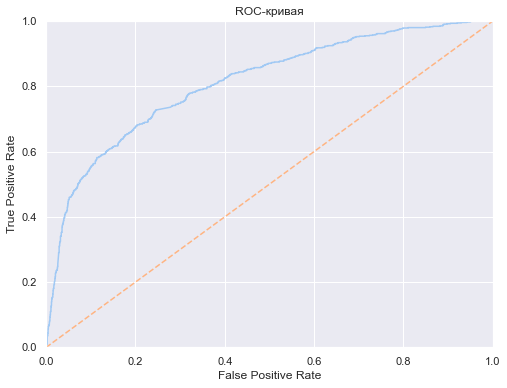

F1: 0.593
ROC_auc: 0.709
Precision: 0.773
Recall: 0.482


In [82]:
results(model_catboost_class_bow, X_test_bow, y_test_class)

### Подводим итоги по моделям классификации

На мой взгляд, нам удались модели классификации. Метрика F1 предсказана на высоком уровне более 0,6. Сведем результаты в таблице и взглянем на результаты на тестовых выборках.

In [65]:
#Проверка на тестовой BOW
f1_lgbm_test_bow = f1_score(y_test_class, prediction_lgbm_class_bow)
print('F1 test LightGBM on BOW: ', f1_lgbm_test_bow)

F1 test LightGBM on BOW:  0.5961389961389961


In [66]:
#Проверка на тестовой TF-IDF
f1_lgbm_test_tfidf = f1_score(y_test_class, prediction_lgbm_class_tfidf)
print('F1 test LightGBM on TF-IDF: ', f1_lgbm_test_tfidf)

F1 test LightGBM on TF-IDF:  0.6021341463414633


In [83]:
#Проверка на тестовой CatBoost
f1_catboost_test_bow = f1_score(y_test_class, prediction_catboost_class_bow)
print('F1 test CatBoost: ', f1_catboost_test_bow)

F1 test CatBoost:  0.5934959349593496


In [84]:
metric_table2 = pd.DataFrame(data=[
    (round(f1_lgbm_bow_cv, 3), round(f1_lgbm_test_bow, 3)),
    (round(f1_lgbm_tfidf_cv, 3), round(f1_lgbm_test_tfidf, 3)),
    (round(f1_catboost_bow_cv, 3), round(f1_catboost_test_bow, 3))
], index=['LightGBM on BOW', 'LightGBM on TF-IDF', 'CatBoost'], columns=['F1 on CV', 'F1 on Test'])

display(metric_table2)

,F1 on CV,F1 on Test
LightGBM on BOW,0.612,0.596
LightGBM on TF-IDF,0.601,0.602
CatBoost,0.581,0.593


Все модели удались и достаточно адекватны. Модель LightGBM on TF-IDF выдает хорошие метрики, на ней остановимся. Посмотрим, какие слова выделила эта модель.

In [85]:
feature_importances_class = sorted(zip(model_lgbm_class_tfidf.best_estimator_.feature_importances_, bow_features), 
                                   reverse=True)[0:40]
feature_importances_class

[(284, 'библиотека'),
 (274, 'выставка'),
 (234, 'год'),
 (211, 'который'),
 (168, 'музей'),
 (162, 'наш'),
 (157, 'искусство'),
 (148, 'работа'),
 (137, 'художник'),
 (130, 'донский'),
 (129, 'день'),
 (123, 'ростовский'),
 (111, 'свой'),
 (94, 'вход'),
 (93, 'фонд'),
 (90, 'проект'),
 (84, 'публичный'),
 (73, 'книга'),
 (72, 'пройти'),
 (72, 'весь'),
 (68, 'состояться'),
 (68, 'свободный'),
 (67, 'история'),
 (64, 'рамка'),
 (64, 'лекция'),
 (57, 'первый'),
 (57, 'жизнь'),
 (55, 'заслужить'),
 (53, 'открытие'),
 (53, 'время'),
 (53, 'билет'),
 (52, 'центр'),
 (51, 'новый'),
 (50, 'рождение'),
 (46, 'программа'),
 (45, 'культура'),
 (45, 'государственный'),
 (40, 'человек'),
 (40, 'встреча'),
 (39, 'дом')]

# Вывод по данной работе

Мы получили список слов, которые, по мнению модели классификации, сильнее всего влияют на популярность поста. Теперь нам нужно свести два списка с популярными словами и сравнить их.

In [69]:
def words_plot(feature_importances, name_of_model):
    df = pd.DataFrame(feature_importances, columns=['importance', 'word'])
    df.set_index('word', inplace=True)
    df.sort_values(by='importance').plot(kind='barh', figsize=(10, 10))
    plt.title(f'График важности слов для модели {name_of_model}')
    plt.tight_layout()
    plt.show()

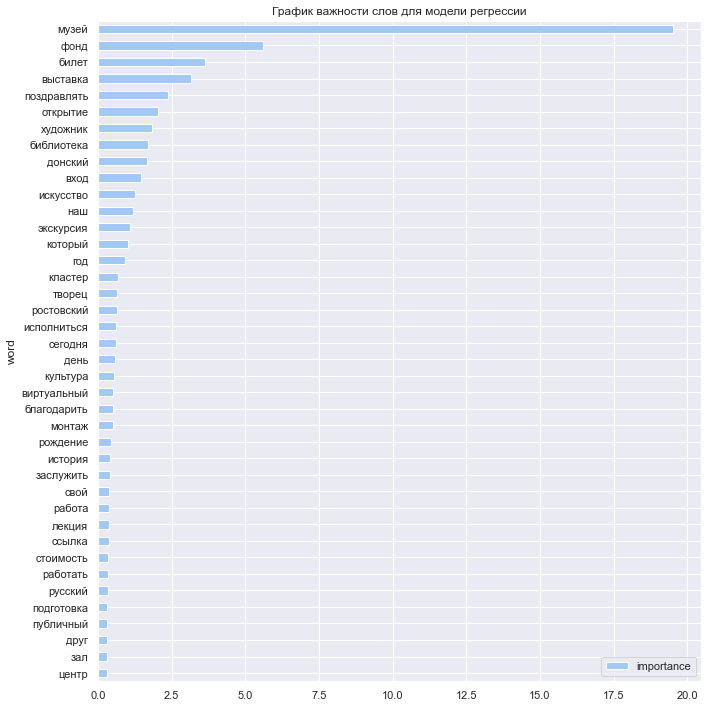

In [86]:
words_plot(feature_importances_reg, 'регрессии')

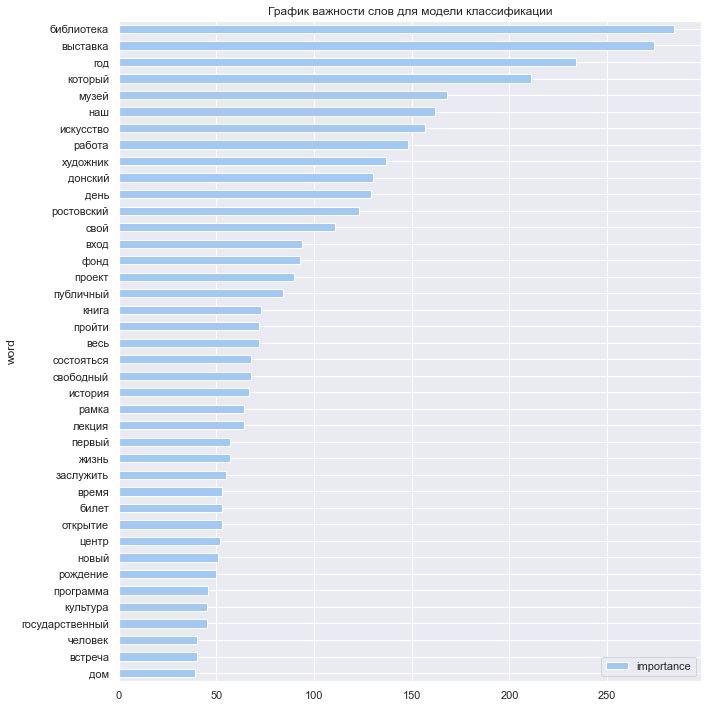

In [87]:
words_plot(feature_importances_class, 'классификации')

Как видим, есть некоторые различия в наборе слов. Далее мы разберем какие слова содержатся в обоих сетах и отберем содержательные.

In [88]:
words_reg = []
for tup in feature_importances_reg:
    words_reg.append(tup[1])
words_reg

['музей',
 'фонд',
 'билет',
 'выставка',
 'поздравлять',
 'открытие',
 'художник',
 'библиотека',
 'донский',
 'вход',
 'искусство',
 'наш',
 'экскурсия',
 'который',
 'год',
 'кластер',
 'творец',
 'ростовский',
 'исполниться',
 'сегодня',
 'день',
 'культура',
 'виртуальный',
 'благодарить',
 'монтаж',
 'рождение',
 'история',
 'заслужить',
 'свой',
 'работа',
 'лекция',
 'ссылка',
 'стоимость',
 'работать',
 'русский',
 'подготовка',
 'публичный',
 'друг',
 'зал',
 'центр']

In [89]:
words_class = []
for tup in feature_importances_class:
    words_class.append(tup[1])
words_class

['библиотека',
 'выставка',
 'год',
 'который',
 'музей',
 'наш',
 'искусство',
 'работа',
 'художник',
 'донский',
 'день',
 'ростовский',
 'свой',
 'вход',
 'фонд',
 'проект',
 'публичный',
 'книга',
 'пройти',
 'весь',
 'состояться',
 'свободный',
 'история',
 'рамка',
 'лекция',
 'первый',
 'жизнь',
 'заслужить',
 'открытие',
 'время',
 'билет',
 'центр',
 'новый',
 'рождение',
 'программа',
 'культура',
 'государственный',
 'человек',
 'встреча',
 'дом']

In [90]:
set_of_words = set(words_reg) & set(words_class)

In [91]:
set_of_words

{'библиотека',
 'билет',
 'вход',
 'выставка',
 'год',
 'день',
 'донский',
 'заслужить',
 'искусство',
 'история',
 'который',
 'культура',
 'лекция',
 'музей',
 'наш',
 'открытие',
 'публичный',
 'работа',
 'рождение',
 'ростовский',
 'свой',
 'фонд',
 'художник',
 'центр'}

У нас получилось немного пересечений. Как видим, в наших группах (посвященных культуре) популярностью пользуются слова, связанные с музеями, выставками, искусством и их атрибутами.

Далее мы объясним более подробно смысл и вес данных слов с помощью библиотеки SHAP на примере одной из моделей.

In [101]:
def shap_importance(model, X, feature_names, title=None, n_iterations=25, MULTIPLIER=1):
    
    X_test_bow_summary = pd.DataFrame(X.toarray(), columns=feature_names)
    X_test_bow_summary = shap.sample(X_test_bow_summary, n_iterations, random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(model.best_estimator_.predict, X_test_bow_summary)

    shap_values = explainer.shap_values(X_test_bow_summary)
    fig = plt.figure()
    fig.suptitle(f'{title}', fontweight='bold')
    ax0 = fig.add_subplot(131)
    exp = Explanation(shap_values * MULTIPLIER, explainer.expected_value, data=X_test_bow_summary,
                      feature_names=X_test_bow_summary.columns)
    shap.summary_plot(shap_values, X_test_bow_summary, plot_type='bar', show=False)
    ax0.set_title('Model SHAP importance')

    ax1 = fig.add_subplot(132)
    shap.summary_plot(shap_values, X_test_bow_summary, show=False)
    ax1.set_title('Model SHAP influence')

    ax2 = fig.add_subplot(133)
    shap.plots.waterfall(exp[0], show=False)
    ax2.set_title('Model SHAP influence to a prediction')

    plt.gcf().set_size_inches(18, 8)
    plt.tight_layout()
    plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

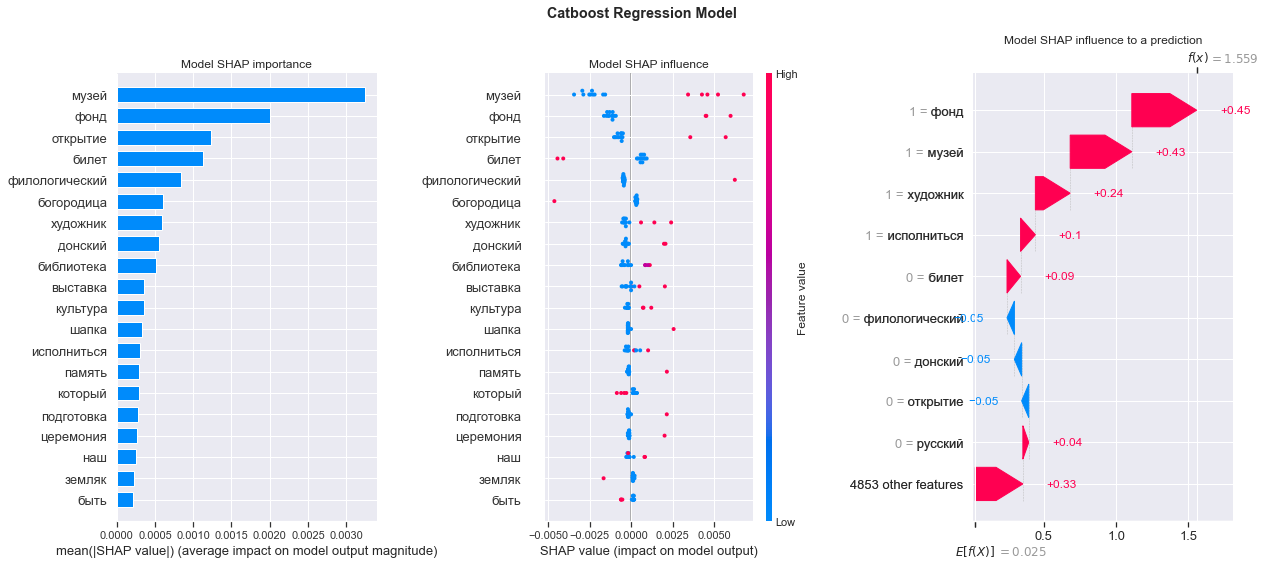

In [104]:
shap_importance(model_catboost_bow, X_test_bow, bow_features, 'Catboost Regression Model', 15, 100)

  0%|          | 0/25 [00:00<?, ?it/s]

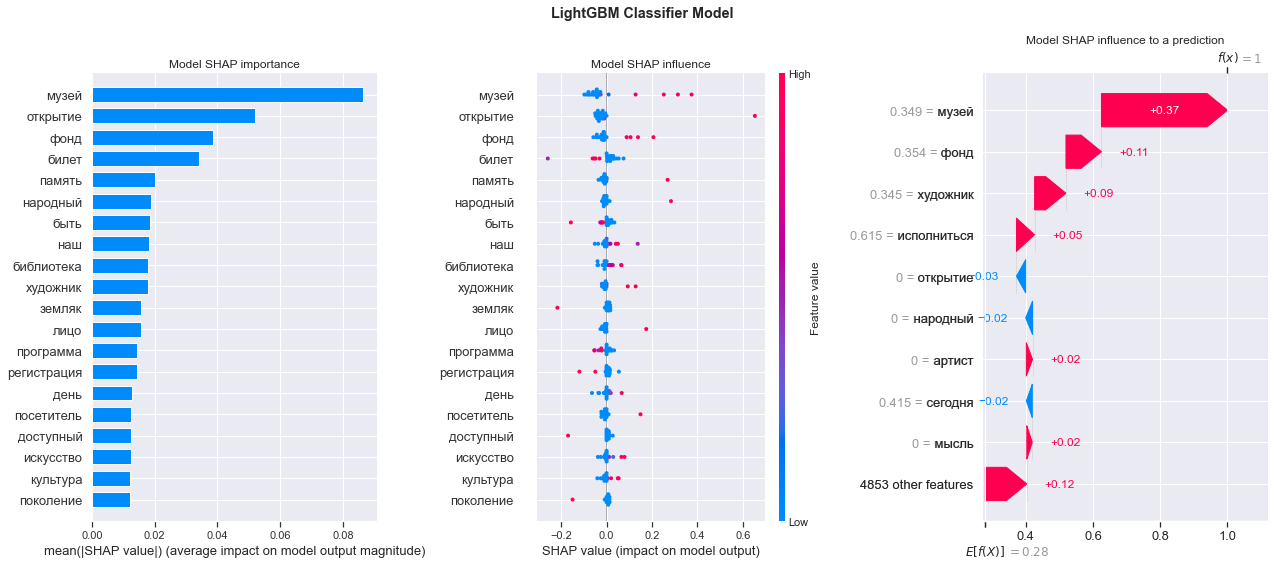

In [97]:
shap_importance(model_lgbm_class_tfidf, X_test_tfidf, tfidf_features, 'LightGBM Classifier Model')

**Вывод:**
- Если отбросить все мусорные слова, то мы можем заметить, что люди обращают внимание на активности, выставки, музеи, библиотеки и тд.
- Они также обращают внимание на место проведения, город.
- Людям важно, чтобы это было в территориальной доступности.
- Важно описать обстоятельства посещения, покупки билетов, времени, входа и тд. 
- Люди в целом падки на громкие слова, вроде "центр", "фонд", "проект", "искусство" как возможность прикоснуться к чему то серьезному.
- Оценят свободное посещение.
- Всегда нужно уточнять время и даты, день, год мероприятия.

Если изучить внимательнее то, что нам выдал SHAP по двум моделям самых популярных слов, то мы однозначно можем увидеть, что в наших группах, посвященных культуре, положительно на популярность поста оказывают влияние слова, которые непосредственно относятся к тематике группы. Это слова: "музей", "фонд", "художник" и тд. Читатели положительно реагируют на тех, кто создает событие. Люди также любят апелляции к патриотическому, упоминаниям чего то "нашего", "памяти", чего то русского. При этом отрицательно на популярность поста влияют слова, связанные со сложностями, к примеру, при посещении музея или иного мероприятия. Пост, где упомитаются билеты, программы, регистрации и проч., могут набирать меньше лайков на количество просмотров. Люди воспринимают эту информацию как дежурную, обременяющую. Также, для увеличения популярности, стоит писать дату мероприятия, день. Людям это интересно.

На данном этапе это все, что можно было вывести из данного исследования. Мы продолжим исследование на заранее подготовленном датафрейме в новой тетрадке Jupyter Notebook `social_networks2`. Цель - углубиться в исследование и выявить насколько важны иные метрики поста для его популярности среди пользователей.